In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 2312)
(657450, 8)
validation
(74368, 2312)
(74368, 8)
test
(91684, 2312)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 2312)]            0         


 dense (Dense)               (None, 1024)              2368512   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 3058568 (11.67 MB)


Trainable params: 3058568 (11.67 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 2:02 - loss: 1.9162 - STD: 0.0451 - MAE: 0.2120

 2/66 [..............................] - ETA: 3s - loss: 1.7032 - STD: 0.0776 - MAE: 0.1952  

 4/66 [>.............................] - ETA: 3s - loss: 1.5423 - STD: 0.1456 - MAE: 0.1668

 6/66 [=>............................] - ETA: 2s - loss: 1.4825 - STD: 0.1792 - MAE: 0.1525

 8/66 [==>...........................] - ETA: 2s - loss: 1.4450 - STD: 0.1909 - MAE: 0.1474

10/66 [===>..........................] - ETA: 2s - loss: 1.4186 - STD: 0.1905 - MAE: 0.1472

12/66 [====>.........................] - ETA: 2s - loss: 1.4059 - STD: 0.1863 - MAE: 0.1487

14/66 [=====>........................] - ETA: 2s - loss: 1.3964 - STD: 0.1834 - MAE: 0.1498

16/66 [======>.......................] - ETA: 2s - loss: 1.3860 - STD: 0.1833 - MAE: 0.1496

18/66 [=======>......................] - ETA: 2s - loss: 1.3772 - STD: 0.1853 - MAE: 0.1486

20/66 [========>.....................] - ETA: 2s - loss: 1.3715 - STD: 0.1882 - MAE: 0.1474

22/66 [=========>....................] - ETA: 2s - loss: 1.3674 - STD: 0.1906 - MAE: 0.1464

24/66 [=========>....................] - ETA: 2s - loss: 1.3632 - STD: 0.1918 - MAE: 0.1459

26/66 [==========>...................] - ETA: 1s - loss: 1.3588 - STD: 0.1918 - MAE: 0.1458

28/66 [===========>..................] - ETA: 1s - loss: 1.3551 - STD: 0.1911 - MAE: 0.1460

30/66 [============>.................] - ETA: 1s - loss: 1.3511 - STD: 0.1904 - MAE: 0.1462

32/66 [=============>................] - ETA: 1s - loss: 1.3474 - STD: 0.1901 - MAE: 0.1462

34/66 [==============>...............] - ETA: 1s - loss: 1.3455 - STD: 0.1903 - MAE: 0.1461

36/66 [===============>..............] - ETA: 1s - loss: 1.3432 - STD: 0.1908 - MAE: 0.1459

38/66 [================>.............] - ETA: 1s - loss: 1.3415 - STD: 0.1913 - MAE: 0.1457

40/66 [=================>............] - ETA: 1s - loss: 1.3403 - STD: 0.1916 - MAE: 0.1456

42/66 [==================>...........] - ETA: 1s - loss: 1.3396 - STD: 0.1917 - MAE: 0.1456

44/66 [===================>..........] - ETA: 1s - loss: 1.3381 - STD: 0.1915 - MAE: 0.1456

46/66 [===================>..........] - ETA: 0s - loss: 1.3363 - STD: 0.1912 - MAE: 0.1457

48/66 [====================>.........] - ETA: 0s - loss: 1.3356 - STD: 0.1911 - MAE: 0.1457

50/66 [=====================>........] - ETA: 0s - loss: 1.3351 - STD: 0.1911 - MAE: 0.1457

52/66 [======================>.......] - ETA: 0s - loss: 1.3347 - STD: 0.1912 - MAE: 0.1457

54/66 [=======================>......] - ETA: 0s - loss: 1.3339 - STD: 0.1913 - MAE: 0.1457

56/66 [========================>.....] - ETA: 0s - loss: 1.3333 - STD: 0.1913 - MAE: 0.1457

58/66 [=========================>....] - ETA: 0s - loss: 1.3320 - STD: 0.1912 - MAE: 0.1457

60/66 [==========================>...] - ETA: 0s - loss: 1.3310 - STD: 0.1912 - MAE: 0.1457

62/66 [===========================>..] - ETA: 0s - loss: 1.3303 - STD: 0.1912 - MAE: 0.1457

64/66 [============================>.] - ETA: 0s - loss: 1.3293 - STD: 0.1912 - MAE: 0.1456

66/66 [==============================] - ETA: 0s - loss: 1.3286 - STD: 0.1913 - MAE: 0.1456

66/66 [==============================] - 7s 80ms/step - loss: 1.3286 - STD: 0.1913 - MAE: 0.1456 - val_loss: 1.2431 - val_STD: 0.1948 - val_MAE: 0.1406


Epoch 2/10000


 1/66 [..............................] - ETA: 7s - loss: 1.2744 - STD: 0.1948 - MAE: 0.1422

 2/66 [..............................] - ETA: 3s - loss: 1.3031 - STD: 0.1949 - MAE: 0.1436

 4/66 [>.............................] - ETA: 3s - loss: 1.3014 - STD: 0.1944 - MAE: 0.1437

 6/66 [=>............................] - ETA: 2s - loss: 1.3021 - STD: 0.1937 - MAE: 0.1440

 8/66 [==>...........................] - ETA: 2s - loss: 1.3009 - STD: 0.1932 - MAE: 0.1441

10/66 [===>..........................] - ETA: 2s - loss: 1.2986 - STD: 0.1931 - MAE: 0.1441

12/66 [====>.........................] - ETA: 2s - loss: 1.3023 - STD: 0.1932 - MAE: 0.1443

14/66 [=====>........................] - ETA: 2s - loss: 1.3047 - STD: 0.1931 - MAE: 0.1444

16/66 [======>.......................] - ETA: 2s - loss: 1.3037 - STD: 0.1927 - MAE: 0.1445

18/66 [=======>......................] - ETA: 2s - loss: 1.3039 - STD: 0.1924 - MAE: 0.1446

20/66 [========>.....................] - ETA: 2s - loss: 1.3030 - STD: 0.1924 - MAE: 0.1446

22/66 [=========>....................] - ETA: 2s - loss: 1.3028 - STD: 0.1925 - MAE: 0.1445

24/66 [=========>....................] - ETA: 2s - loss: 1.3022 - STD: 0.1927 - MAE: 0.1444

26/66 [==========>...................] - ETA: 1s - loss: 1.3027 - STD: 0.1927 - MAE: 0.1445

28/66 [===========>..................] - ETA: 1s - loss: 1.3022 - STD: 0.1925 - MAE: 0.1445

30/66 [============>.................] - ETA: 1s - loss: 1.3024 - STD: 0.1924 - MAE: 0.1446

32/66 [=============>................] - ETA: 1s - loss: 1.3017 - STD: 0.1923 - MAE: 0.1446

34/66 [==============>...............] - ETA: 1s - loss: 1.3013 - STD: 0.1923 - MAE: 0.1445

36/66 [===============>..............] - ETA: 1s - loss: 1.3011 - STD: 0.1922 - MAE: 0.1445

38/66 [================>.............] - ETA: 1s - loss: 1.3006 - STD: 0.1922 - MAE: 0.1445

40/66 [=================>............] - ETA: 1s - loss: 1.3000 - STD: 0.1922 - MAE: 0.1445

42/66 [==================>...........] - ETA: 1s - loss: 1.2988 - STD: 0.1922 - MAE: 0.1444

44/66 [===================>..........] - ETA: 1s - loss: 1.2976 - STD: 0.1923 - MAE: 0.1443

46/66 [===================>..........] - ETA: 0s - loss: 1.2971 - STD: 0.1923 - MAE: 0.1442

48/66 [====================>.........] - ETA: 0s - loss: 1.2961 - STD: 0.1922 - MAE: 0.1442

50/66 [=====================>........] - ETA: 0s - loss: 1.2941 - STD: 0.1924 - MAE: 0.1440

52/66 [======================>.......] - ETA: 0s - loss: 1.2932 - STD: 0.1925 - MAE: 0.1439

54/66 [=======================>......] - ETA: 0s - loss: 1.2922 - STD: 0.1924 - MAE: 0.1439

56/66 [========================>.....] - ETA: 0s - loss: 1.2912 - STD: 0.1927 - MAE: 0.1437

58/66 [=========================>....] - ETA: 0s - loss: 1.2899 - STD: 0.1927 - MAE: 0.1436

60/66 [==========================>...] - ETA: 0s - loss: 1.2883 - STD: 0.1928 - MAE: 0.1435

62/66 [===========================>..] - ETA: 0s - loss: 1.2872 - STD: 0.1932 - MAE: 0.1433

64/66 [============================>.] - ETA: 0s - loss: 1.2861 - STD: 0.1932 - MAE: 0.1432

66/66 [==============================] - ETA: 0s - loss: 1.2848 - STD: 0.1934 - MAE: 0.1431

66/66 [==============================] - 4s 55ms/step - loss: 1.2848 - STD: 0.1934 - MAE: 0.1431 - val_loss: 1.1780 - val_STD: 0.2153 - val_MAE: 0.1281


Epoch 3/10000


 1/66 [..............................] - ETA: 6s - loss: 1.2408 - STD: 0.2081 - MAE: 0.1350

 3/66 [>.............................] - ETA: 3s - loss: 1.2406 - STD: 0.2009 - MAE: 0.1379

 5/66 [=>............................] - ETA: 2s - loss: 1.2426 - STD: 0.1993 - MAE: 0.1387

 7/66 [==>...........................] - ETA: 2s - loss: 1.2419 - STD: 0.2006 - MAE: 0.1383

 9/66 [===>..........................] - ETA: 2s - loss: 1.2443 - STD: 0.1986 - MAE: 0.1392

11/66 [====>.........................] - ETA: 2s - loss: 1.2413 - STD: 0.1996 - MAE: 0.1387

13/66 [====>.........................] - ETA: 2s - loss: 1.2406 - STD: 0.1995 - MAE: 0.1387

15/66 [=====>........................] - ETA: 2s - loss: 1.2372 - STD: 0.1996 - MAE: 0.1385

17/66 [======>.......................] - ETA: 2s - loss: 1.2354 - STD: 0.2004 - MAE: 0.1381

19/66 [=======>......................] - ETA: 2s - loss: 1.2341 - STD: 0.1999 - MAE: 0.1383

21/66 [========>.....................] - ETA: 2s - loss: 1.2335 - STD: 0.2006 - MAE: 0.1380

23/66 [=========>....................] - ETA: 2s - loss: 1.2320 - STD: 0.1999 - MAE: 0.1382

25/66 [==========>...................] - ETA: 1s - loss: 1.2298 - STD: 0.2005 - MAE: 0.1379

27/66 [===========>..................] - ETA: 1s - loss: 1.2284 - STD: 0.2004 - MAE: 0.1380

29/66 [============>.................] - ETA: 1s - loss: 1.2271 - STD: 0.2003 - MAE: 0.1380

31/66 [=============>................] - ETA: 1s - loss: 1.2247 - STD: 0.2005 - MAE: 0.1378

33/66 [==============>...............] - ETA: 1s - loss: 1.2227 - STD: 0.2006 - MAE: 0.1377

35/66 [==============>...............] - ETA: 1s - loss: 1.2206 - STD: 0.2005 - MAE: 0.1377

37/66 [===============>..............] - ETA: 1s - loss: 1.2176 - STD: 0.2008 - MAE: 0.1375

39/66 [================>.............] - ETA: 1s - loss: 1.2156 - STD: 0.2008 - MAE: 0.1374

41/66 [=================>............] - ETA: 1s - loss: 1.2136 - STD: 0.2009 - MAE: 0.1374

43/66 [==================>...........] - ETA: 1s - loss: 1.2107 - STD: 0.2010 - MAE: 0.1373

45/66 [===================>..........] - ETA: 1s - loss: 1.2080 - STD: 0.2011 - MAE: 0.1371

47/66 [====================>.........] - ETA: 0s - loss: 1.2048 - STD: 0.2010 - MAE: 0.1371

49/66 [=====================>........] - ETA: 0s - loss: 1.2021 - STD: 0.2011 - MAE: 0.1369

51/66 [======================>.......] - ETA: 0s - loss: 1.1995 - STD: 0.2014 - MAE: 0.1367

53/66 [=======================>......] - ETA: 0s - loss: 1.1966 - STD: 0.2015 - MAE: 0.1366

55/66 [========================>.....] - ETA: 0s - loss: 1.1941 - STD: 0.2015 - MAE: 0.1365

57/66 [========================>.....] - ETA: 0s - loss: 1.1912 - STD: 0.2017 - MAE: 0.1364

58/66 [=========================>....] - ETA: 0s - loss: 1.1899 - STD: 0.2018 - MAE: 0.1363

60/66 [==========================>...] - ETA: 0s - loss: 1.1872 - STD: 0.2018 - MAE: 0.1362

62/66 [===========================>..] - ETA: 0s - loss: 1.1849 - STD: 0.2018 - MAE: 0.1362

64/66 [============================>.] - ETA: 0s - loss: 1.1832 - STD: 0.2020 - MAE: 0.1361

66/66 [==============================] - ETA: 0s - loss: 1.1809 - STD: 0.2021 - MAE: 0.1360

66/66 [==============================] - 4s 54ms/step - loss: 1.1809 - STD: 0.2021 - MAE: 0.1360 - val_loss: 1.0410 - val_STD: 0.2140 - val_MAE: 0.1245


Epoch 4/10000


 1/66 [..............................] - ETA: 6s - loss: 1.0994 - STD: 0.2071 - MAE: 0.1321

 3/66 [>.............................] - ETA: 3s - loss: 1.0939 - STD: 0.2045 - MAE: 0.1325

 5/66 [=>............................] - ETA: 2s - loss: 1.0956 - STD: 0.2056 - MAE: 0.1322

 7/66 [==>...........................] - ETA: 2s - loss: 1.0925 - STD: 0.2062 - MAE: 0.1318

 9/66 [===>..........................] - ETA: 2s - loss: 1.0878 - STD: 0.2072 - MAE: 0.1311

11/66 [====>.........................] - ETA: 2s - loss: 1.0865 - STD: 0.2060 - MAE: 0.1316

13/66 [====>.........................] - ETA: 2s - loss: 1.0855 - STD: 0.2076 - MAE: 0.1309

15/66 [=====>........................] - ETA: 2s - loss: 1.0813 - STD: 0.2061 - MAE: 0.1313

17/66 [======>.......................] - ETA: 2s - loss: 1.0800 - STD: 0.2072 - MAE: 0.1308

19/66 [=======>......................] - ETA: 2s - loss: 1.0772 - STD: 0.2072 - MAE: 0.1307

21/66 [========>.....................] - ETA: 2s - loss: 1.0749 - STD: 0.2076 - MAE: 0.1304

23/66 [=========>....................] - ETA: 2s - loss: 1.0726 - STD: 0.2081 - MAE: 0.1301

25/66 [==========>...................] - ETA: 1s - loss: 1.0699 - STD: 0.2081 - MAE: 0.1300

27/66 [===========>..................] - ETA: 1s - loss: 1.0684 - STD: 0.2087 - MAE: 0.1297

29/66 [============>.................] - ETA: 1s - loss: 1.0657 - STD: 0.2086 - MAE: 0.1296

31/66 [=============>................] - ETA: 1s - loss: 1.0630 - STD: 0.2091 - MAE: 0.1293

32/66 [=============>................] - ETA: 1s - loss: 1.0627 - STD: 0.2091 - MAE: 0.1293

34/66 [==============>...............] - ETA: 1s - loss: 1.0612 - STD: 0.2094 - MAE: 0.1291

36/66 [===============>..............] - ETA: 1s - loss: 1.0593 - STD: 0.2094 - MAE: 0.1290

38/66 [================>.............] - ETA: 1s - loss: 1.0574 - STD: 0.2097 - MAE: 0.1288

40/66 [=================>............] - ETA: 1s - loss: 1.0548 - STD: 0.2100 - MAE: 0.1285

42/66 [==================>...........] - ETA: 1s - loss: 1.0533 - STD: 0.2103 - MAE: 0.1284

44/66 [===================>..........] - ETA: 1s - loss: 1.0510 - STD: 0.2105 - MAE: 0.1282

46/66 [===================>..........] - ETA: 0s - loss: 1.0492 - STD: 0.2105 - MAE: 0.1281

48/66 [====================>.........] - ETA: 0s - loss: 1.0474 - STD: 0.2107 - MAE: 0.1279

50/66 [=====================>........] - ETA: 0s - loss: 1.0466 - STD: 0.2110 - MAE: 0.1278

52/66 [======================>.......] - ETA: 0s - loss: 1.0450 - STD: 0.2114 - MAE: 0.1275

54/66 [=======================>......] - ETA: 0s - loss: 1.0438 - STD: 0.2115 - MAE: 0.1274

56/66 [========================>.....] - ETA: 0s - loss: 1.0426 - STD: 0.2116 - MAE: 0.1273

58/66 [=========================>....] - ETA: 0s - loss: 1.0409 - STD: 0.2121 - MAE: 0.1270

60/66 [==========================>...] - ETA: 0s - loss: 1.0392 - STD: 0.2120 - MAE: 0.1270

62/66 [===========================>..] - ETA: 0s - loss: 1.0380 - STD: 0.2123 - MAE: 0.1268

64/66 [============================>.] - ETA: 0s - loss: 1.0367 - STD: 0.2124 - MAE: 0.1267

66/66 [==============================] - ETA: 0s - loss: 1.0355 - STD: 0.2127 - MAE: 0.1266

66/66 [==============================] - 4s 55ms/step - loss: 1.0355 - STD: 0.2127 - MAE: 0.1266 - val_loss: 0.9562 - val_STD: 0.2131 - val_MAE: 0.1209


Epoch 5/10000


 1/66 [..............................] - ETA: 6s - loss: 0.9969 - STD: 0.2056 - MAE: 0.1275

 3/66 [>.............................] - ETA: 3s - loss: 0.9884 - STD: 0.2199 - MAE: 0.1210

 5/66 [=>............................] - ETA: 2s - loss: 0.9891 - STD: 0.2148 - MAE: 0.1233

 7/66 [==>...........................] - ETA: 2s - loss: 0.9879 - STD: 0.2194 - MAE: 0.1213

 9/66 [===>..........................] - ETA: 2s - loss: 0.9877 - STD: 0.2170 - MAE: 0.1224

11/66 [====>.........................] - ETA: 2s - loss: 0.9875 - STD: 0.2179 - MAE: 0.1220

13/66 [====>.........................] - ETA: 2s - loss: 0.9854 - STD: 0.2183 - MAE: 0.1217

15/66 [=====>........................] - ETA: 2s - loss: 0.9839 - STD: 0.2183 - MAE: 0.1217

17/66 [======>.......................] - ETA: 2s - loss: 0.9828 - STD: 0.2189 - MAE: 0.1213

19/66 [=======>......................] - ETA: 2s - loss: 0.9816 - STD: 0.2186 - MAE: 0.1214

21/66 [========>.....................] - ETA: 2s - loss: 0.9799 - STD: 0.2195 - MAE: 0.1209

23/66 [=========>....................] - ETA: 2s - loss: 0.9783 - STD: 0.2189 - MAE: 0.1211

25/66 [==========>...................] - ETA: 1s - loss: 0.9771 - STD: 0.2195 - MAE: 0.1208

27/66 [===========>..................] - ETA: 1s - loss: 0.9766 - STD: 0.2191 - MAE: 0.1209

29/66 [============>.................] - ETA: 1s - loss: 0.9758 - STD: 0.2195 - MAE: 0.1207

31/66 [=============>................] - ETA: 1s - loss: 0.9742 - STD: 0.2198 - MAE: 0.1205

33/66 [==============>...............] - ETA: 1s - loss: 0.9735 - STD: 0.2197 - MAE: 0.1205

35/66 [==============>...............] - ETA: 1s - loss: 0.9713 - STD: 0.2201 - MAE: 0.1202

37/66 [===============>..............] - ETA: 1s - loss: 0.9702 - STD: 0.2200 - MAE: 0.1202

39/66 [================>.............] - ETA: 1s - loss: 0.9696 - STD: 0.2202 - MAE: 0.1201

41/66 [=================>............] - ETA: 1s - loss: 0.9688 - STD: 0.2207 - MAE: 0.1198

43/66 [==================>...........] - ETA: 1s - loss: 0.9682 - STD: 0.2204 - MAE: 0.1199

45/66 [===================>..........] - ETA: 1s - loss: 0.9684 - STD: 0.2206 - MAE: 0.1198

47/66 [====================>.........] - ETA: 0s - loss: 0.9679 - STD: 0.2210 - MAE: 0.1196

49/66 [=====================>........] - ETA: 0s - loss: 0.9672 - STD: 0.2207 - MAE: 0.1197

51/66 [======================>.......] - ETA: 0s - loss: 0.9660 - STD: 0.2212 - MAE: 0.1194

53/66 [=======================>......] - ETA: 0s - loss: 0.9652 - STD: 0.2209 - MAE: 0.1195

55/66 [========================>.....] - ETA: 0s - loss: 0.9639 - STD: 0.2214 - MAE: 0.1193

57/66 [========================>.....] - ETA: 0s - loss: 0.9631 - STD: 0.2212 - MAE: 0.1193

59/66 [=========================>....] - ETA: 0s - loss: 0.9617 - STD: 0.2215 - MAE: 0.1191

61/66 [==========================>...] - ETA: 0s - loss: 0.9601 - STD: 0.2216 - MAE: 0.1190

63/66 [===========================>..] - ETA: 0s - loss: 0.9586 - STD: 0.2217 - MAE: 0.1188

65/66 [============================>.] - ETA: 0s - loss: 0.9573 - STD: 0.2218 - MAE: 0.1187

66/66 [==============================] - 4s 54ms/step - loss: 0.9566 - STD: 0.2219 - MAE: 0.1186 - val_loss: 0.9049 - val_STD: 0.2323 - val_MAE: 0.1099


Epoch 6/10000


 1/66 [..............................] - ETA: 7s - loss: 0.9238 - STD: 0.2245 - MAE: 0.1155

 3/66 [>.............................] - ETA: 3s - loss: 0.9151 - STD: 0.2256 - MAE: 0.1148

 5/66 [=>............................] - ETA: 2s - loss: 0.9107 - STD: 0.2254 - MAE: 0.1147

 7/66 [==>...........................] - ETA: 2s - loss: 0.9118 - STD: 0.2268 - MAE: 0.1142

 9/66 [===>..........................] - ETA: 2s - loss: 0.9146 - STD: 0.2266 - MAE: 0.1144

11/66 [====>.........................] - ETA: 2s - loss: 0.9150 - STD: 0.2266 - MAE: 0.1144

13/66 [====>.........................] - ETA: 2s - loss: 0.9158 - STD: 0.2270 - MAE: 0.1143

15/66 [=====>........................] - ETA: 2s - loss: 0.9171 - STD: 0.2266 - MAE: 0.1146

17/66 [======>.......................] - ETA: 2s - loss: 0.9159 - STD: 0.2270 - MAE: 0.1144

19/66 [=======>......................] - ETA: 2s - loss: 0.9161 - STD: 0.2269 - MAE: 0.1144

21/66 [========>.....................] - ETA: 2s - loss: 0.9155 - STD: 0.2268 - MAE: 0.1144

23/66 [=========>....................] - ETA: 2s - loss: 0.9164 - STD: 0.2273 - MAE: 0.1143

25/66 [==========>...................] - ETA: 1s - loss: 0.9150 - STD: 0.2269 - MAE: 0.1144

27/66 [===========>..................] - ETA: 1s - loss: 0.9139 - STD: 0.2272 - MAE: 0.1143

29/66 [============>.................] - ETA: 1s - loss: 0.9132 - STD: 0.2273 - MAE: 0.1142

31/66 [=============>................] - ETA: 1s - loss: 0.9116 - STD: 0.2271 - MAE: 0.1142

33/66 [==============>...............] - ETA: 1s - loss: 0.9098 - STD: 0.2275 - MAE: 0.1140

35/66 [==============>...............] - ETA: 1s - loss: 0.9087 - STD: 0.2273 - MAE: 0.1140

37/66 [===============>..............] - ETA: 1s - loss: 0.9075 - STD: 0.2276 - MAE: 0.1138

39/66 [================>.............] - ETA: 1s - loss: 0.9054 - STD: 0.2276 - MAE: 0.1137

41/66 [=================>............] - ETA: 1s - loss: 0.9040 - STD: 0.2277 - MAE: 0.1136

43/66 [==================>...........] - ETA: 1s - loss: 0.9030 - STD: 0.2279 - MAE: 0.1135

45/66 [===================>..........] - ETA: 1s - loss: 0.9019 - STD: 0.2278 - MAE: 0.1135

47/66 [====================>.........] - ETA: 0s - loss: 0.9005 - STD: 0.2279 - MAE: 0.1133

49/66 [=====================>........] - ETA: 0s - loss: 0.8988 - STD: 0.2280 - MAE: 0.1132

51/66 [======================>.......] - ETA: 0s - loss: 0.8977 - STD: 0.2281 - MAE: 0.1132

53/66 [=======================>......] - ETA: 0s - loss: 0.8969 - STD: 0.2282 - MAE: 0.1131

55/66 [========================>.....] - ETA: 0s - loss: 0.8956 - STD: 0.2283 - MAE: 0.1130

57/66 [========================>.....] - ETA: 0s - loss: 0.8943 - STD: 0.2283 - MAE: 0.1129

59/66 [=========================>....] - ETA: 0s - loss: 0.8937 - STD: 0.2284 - MAE: 0.1129

61/66 [==========================>...] - ETA: 0s - loss: 0.8927 - STD: 0.2287 - MAE: 0.1127

63/66 [===========================>..] - ETA: 0s - loss: 0.8917 - STD: 0.2286 - MAE: 0.1127

65/66 [============================>.] - ETA: 0s - loss: 0.8908 - STD: 0.2287 - MAE: 0.1126

66/66 [==============================] - 4s 55ms/step - loss: 0.8904 - STD: 0.2289 - MAE: 0.1125 - val_loss: 0.8730 - val_STD: 0.2418 - val_MAE: 0.1050


Epoch 7/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8559 - STD: 0.2335 - MAE: 0.1091

 3/66 [>.............................] - ETA: 3s - loss: 0.8552 - STD: 0.2315 - MAE: 0.1101

 5/66 [=>............................] - ETA: 2s - loss: 0.8532 - STD: 0.2311 - MAE: 0.1101

 7/66 [==>...........................] - ETA: 2s - loss: 0.8523 - STD: 0.2317 - MAE: 0.1098

 9/66 [===>..........................] - ETA: 2s - loss: 0.8500 - STD: 0.2310 - MAE: 0.1100

11/66 [====>.........................] - ETA: 2s - loss: 0.8507 - STD: 0.2313 - MAE: 0.1099

13/66 [====>.........................] - ETA: 2s - loss: 0.8493 - STD: 0.2316 - MAE: 0.1097

15/66 [=====>........................] - ETA: 2s - loss: 0.8482 - STD: 0.2311 - MAE: 0.1099

17/66 [======>.......................] - ETA: 2s - loss: 0.8478 - STD: 0.2315 - MAE: 0.1097

19/66 [=======>......................] - ETA: 2s - loss: 0.8489 - STD: 0.2315 - MAE: 0.1097

21/66 [========>.....................] - ETA: 2s - loss: 0.8509 - STD: 0.2315 - MAE: 0.1099

23/66 [=========>....................] - ETA: 2s - loss: 0.8505 - STD: 0.2320 - MAE: 0.1097

25/66 [==========>...................] - ETA: 1s - loss: 0.8535 - STD: 0.2325 - MAE: 0.1096

27/66 [===========>..................] - ETA: 1s - loss: 0.8536 - STD: 0.2317 - MAE: 0.1100

29/66 [============>.................] - ETA: 1s - loss: 0.8537 - STD: 0.2326 - MAE: 0.1096

31/66 [=============>................] - ETA: 1s - loss: 0.8534 - STD: 0.2319 - MAE: 0.1099

33/66 [==============>...............] - ETA: 1s - loss: 0.8539 - STD: 0.2322 - MAE: 0.1098

35/66 [==============>...............] - ETA: 1s - loss: 0.8535 - STD: 0.2322 - MAE: 0.1098

37/66 [===============>..............] - ETA: 1s - loss: 0.8528 - STD: 0.2322 - MAE: 0.1098

39/66 [================>.............] - ETA: 1s - loss: 0.8515 - STD: 0.2324 - MAE: 0.1096

41/66 [=================>............] - ETA: 1s - loss: 0.8504 - STD: 0.2323 - MAE: 0.1096

43/66 [==================>...........] - ETA: 1s - loss: 0.8492 - STD: 0.2325 - MAE: 0.1095

45/66 [===================>..........] - ETA: 1s - loss: 0.8487 - STD: 0.2324 - MAE: 0.1095

47/66 [====================>.........] - ETA: 0s - loss: 0.8474 - STD: 0.2327 - MAE: 0.1093

49/66 [=====================>........] - ETA: 0s - loss: 0.8461 - STD: 0.2325 - MAE: 0.1093

51/66 [======================>.......] - ETA: 0s - loss: 0.8455 - STD: 0.2327 - MAE: 0.1092

53/66 [=======================>......] - ETA: 0s - loss: 0.8450 - STD: 0.2327 - MAE: 0.1092

55/66 [========================>.....] - ETA: 0s - loss: 0.8445 - STD: 0.2328 - MAE: 0.1092

57/66 [========================>.....] - ETA: 0s - loss: 0.8437 - STD: 0.2328 - MAE: 0.1091

59/66 [=========================>....] - ETA: 0s - loss: 0.8428 - STD: 0.2329 - MAE: 0.1090

61/66 [==========================>...] - ETA: 0s - loss: 0.8422 - STD: 0.2328 - MAE: 0.1090

63/66 [===========================>..] - ETA: 0s - loss: 0.8413 - STD: 0.2329 - MAE: 0.1089

65/66 [============================>.] - ETA: 0s - loss: 0.8406 - STD: 0.2330 - MAE: 0.1089

66/66 [==============================] - 4s 55ms/step - loss: 0.8404 - STD: 0.2330 - MAE: 0.1088 - val_loss: 0.8556 - val_STD: 0.2434 - val_MAE: 0.1040


Epoch 8/10000


 1/66 [..............................] - ETA: 7s - loss: 0.8113 - STD: 0.2345 - MAE: 0.1069

 3/66 [>.............................] - ETA: 3s - loss: 0.8112 - STD: 0.2358 - MAE: 0.1060

 5/66 [=>............................] - ETA: 2s - loss: 0.8065 - STD: 0.2359 - MAE: 0.1058

 7/66 [==>...........................] - ETA: 2s - loss: 0.8090 - STD: 0.2356 - MAE: 0.1061

 9/66 [===>..........................] - ETA: 2s - loss: 0.8098 - STD: 0.2353 - MAE: 0.1063

11/66 [====>.........................] - ETA: 2s - loss: 0.8119 - STD: 0.2354 - MAE: 0.1064

13/66 [====>.........................] - ETA: 2s - loss: 0.8152 - STD: 0.2351 - MAE: 0.1067

15/66 [=====>........................] - ETA: 2s - loss: 0.8170 - STD: 0.2351 - MAE: 0.1068

17/66 [======>.......................] - ETA: 2s - loss: 0.8197 - STD: 0.2357 - MAE: 0.1066

19/66 [=======>......................] - ETA: 2s - loss: 0.8205 - STD: 0.2352 - MAE: 0.1069

21/66 [========>.....................] - ETA: 2s - loss: 0.8207 - STD: 0.2354 - MAE: 0.1068

23/66 [=========>....................] - ETA: 2s - loss: 0.8199 - STD: 0.2353 - MAE: 0.1068

25/66 [==========>...................] - ETA: 1s - loss: 0.8207 - STD: 0.2355 - MAE: 0.1068

27/66 [===========>..................] - ETA: 1s - loss: 0.8203 - STD: 0.2353 - MAE: 0.1068

29/66 [============>.................] - ETA: 1s - loss: 0.8196 - STD: 0.2357 - MAE: 0.1066

31/66 [=============>................] - ETA: 1s - loss: 0.8189 - STD: 0.2356 - MAE: 0.1066

33/66 [==============>...............] - ETA: 1s - loss: 0.8184 - STD: 0.2356 - MAE: 0.1066

35/66 [==============>...............] - ETA: 1s - loss: 0.8174 - STD: 0.2357 - MAE: 0.1065

37/66 [===============>..............] - ETA: 1s - loss: 0.8165 - STD: 0.2355 - MAE: 0.1066

39/66 [================>.............] - ETA: 1s - loss: 0.8156 - STD: 0.2358 - MAE: 0.1064

41/66 [=================>............] - ETA: 1s - loss: 0.8150 - STD: 0.2357 - MAE: 0.1064

43/66 [==================>...........] - ETA: 1s - loss: 0.8144 - STD: 0.2359 - MAE: 0.1063

45/66 [===================>..........] - ETA: 1s - loss: 0.8140 - STD: 0.2358 - MAE: 0.1063

47/66 [====================>.........] - ETA: 0s - loss: 0.8133 - STD: 0.2359 - MAE: 0.1062

48/66 [====================>.........] - ETA: 0s - loss: 0.8130 - STD: 0.2360 - MAE: 0.1062

50/66 [=====================>........] - ETA: 0s - loss: 0.8132 - STD: 0.2360 - MAE: 0.1062

52/66 [======================>.......] - ETA: 0s - loss: 0.8130 - STD: 0.2359 - MAE: 0.1063

54/66 [=======================>......] - ETA: 0s - loss: 0.8133 - STD: 0.2359 - MAE: 0.1063

56/66 [========================>.....] - ETA: 0s - loss: 0.8129 - STD: 0.2360 - MAE: 0.1062

58/66 [=========================>....] - ETA: 0s - loss: 0.8119 - STD: 0.2360 - MAE: 0.1062

60/66 [==========================>...] - ETA: 0s - loss: 0.8112 - STD: 0.2361 - MAE: 0.1061

62/66 [===========================>..] - ETA: 0s - loss: 0.8107 - STD: 0.2361 - MAE: 0.1061

64/66 [============================>.] - ETA: 0s - loss: 0.8103 - STD: 0.2361 - MAE: 0.1060

66/66 [==============================] - ETA: 0s - loss: 0.8099 - STD: 0.2361 - MAE: 0.1060

66/66 [==============================] - 4s 54ms/step - loss: 0.8099 - STD: 0.2361 - MAE: 0.1060 - val_loss: 0.8599 - val_STD: 0.2499 - val_MAE: 0.1010


Epoch 9/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7834 - STD: 0.2402 - MAE: 0.1028

 3/66 [>.............................] - ETA: 3s - loss: 0.7839 - STD: 0.2382 - MAE: 0.1037

 5/66 [=>............................] - ETA: 2s - loss: 0.7903 - STD: 0.2377 - MAE: 0.1043

 7/66 [==>...........................] - ETA: 2s - loss: 0.7899 - STD: 0.2386 - MAE: 0.1040

 9/66 [===>..........................] - ETA: 2s - loss: 0.7956 - STD: 0.2381 - MAE: 0.1045

11/66 [====>.........................] - ETA: 2s - loss: 0.7967 - STD: 0.2383 - MAE: 0.1045

13/66 [====>.........................] - ETA: 2s - loss: 0.7959 - STD: 0.2386 - MAE: 0.1042

15/66 [=====>........................] - ETA: 2s - loss: 0.7957 - STD: 0.2387 - MAE: 0.1042

17/66 [======>.......................] - ETA: 2s - loss: 0.7972 - STD: 0.2385 - MAE: 0.1043

19/66 [=======>......................] - ETA: 2s - loss: 0.7975 - STD: 0.2383 - MAE: 0.1045

21/66 [========>.....................] - ETA: 2s - loss: 0.7980 - STD: 0.2383 - MAE: 0.1045

23/66 [=========>....................] - ETA: 2s - loss: 0.7962 - STD: 0.2384 - MAE: 0.1043

25/66 [==========>...................] - ETA: 1s - loss: 0.7947 - STD: 0.2384 - MAE: 0.1043

27/66 [===========>..................] - ETA: 1s - loss: 0.7939 - STD: 0.2383 - MAE: 0.1043

29/66 [============>.................] - ETA: 1s - loss: 0.7937 - STD: 0.2382 - MAE: 0.1043

31/66 [=============>................] - ETA: 1s - loss: 0.7935 - STD: 0.2381 - MAE: 0.1044

33/66 [==============>...............] - ETA: 1s - loss: 0.7935 - STD: 0.2382 - MAE: 0.1043

35/66 [==============>...............] - ETA: 1s - loss: 0.7936 - STD: 0.2381 - MAE: 0.1044

37/66 [===============>..............] - ETA: 1s - loss: 0.7932 - STD: 0.2381 - MAE: 0.1044

39/66 [================>.............] - ETA: 1s - loss: 0.7933 - STD: 0.2380 - MAE: 0.1044

41/66 [=================>............] - ETA: 1s - loss: 0.7933 - STD: 0.2381 - MAE: 0.1044

43/66 [==================>...........] - ETA: 1s - loss: 0.7928 - STD: 0.2383 - MAE: 0.1042

45/66 [===================>..........] - ETA: 1s - loss: 0.7939 - STD: 0.2383 - MAE: 0.1044

47/66 [====================>.........] - ETA: 0s - loss: 0.7932 - STD: 0.2381 - MAE: 0.1044

49/66 [=====================>........] - ETA: 0s - loss: 0.7928 - STD: 0.2381 - MAE: 0.1044

51/66 [======================>.......] - ETA: 0s - loss: 0.7923 - STD: 0.2383 - MAE: 0.1043

52/66 [======================>.......] - ETA: 0s - loss: 0.7923 - STD: 0.2381 - MAE: 0.1044

54/66 [=======================>......] - ETA: 0s - loss: 0.7927 - STD: 0.2382 - MAE: 0.1043

56/66 [========================>.....] - ETA: 0s - loss: 0.7920 - STD: 0.2382 - MAE: 0.1043

58/66 [=========================>....] - ETA: 0s - loss: 0.7917 - STD: 0.2383 - MAE: 0.1042

60/66 [==========================>...] - ETA: 0s - loss: 0.7911 - STD: 0.2382 - MAE: 0.1043

62/66 [===========================>..] - ETA: 0s - loss: 0.7904 - STD: 0.2383 - MAE: 0.1042

64/66 [============================>.] - ETA: 0s - loss: 0.7903 - STD: 0.2383 - MAE: 0.1042

66/66 [==============================] - ETA: 0s - loss: 0.7905 - STD: 0.2384 - MAE: 0.1041

66/66 [==============================] - 4s 55ms/step - loss: 0.7905 - STD: 0.2384 - MAE: 0.1041 - val_loss: 0.8344 - val_STD: 0.2395 - val_MAE: 0.1054


Epoch 10/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7901 - STD: 0.2298 - MAE: 0.1079

 3/66 [>.............................] - ETA: 3s - loss: 0.7865 - STD: 0.2375 - MAE: 0.1042

 5/66 [=>............................] - ETA: 2s - loss: 0.7865 - STD: 0.2364 - MAE: 0.1047

 7/66 [==>...........................] - ETA: 2s - loss: 0.7843 - STD: 0.2382 - MAE: 0.1038

 9/66 [===>..........................] - ETA: 2s - loss: 0.7821 - STD: 0.2377 - MAE: 0.1040

11/66 [====>.........................] - ETA: 2s - loss: 0.7833 - STD: 0.2385 - MAE: 0.1037

13/66 [====>.........................] - ETA: 2s - loss: 0.7845 - STD: 0.2388 - MAE: 0.1036

15/66 [=====>........................] - ETA: 2s - loss: 0.7841 - STD: 0.2395 - MAE: 0.1033

17/66 [======>.......................] - ETA: 2s - loss: 0.7843 - STD: 0.2386 - MAE: 0.1038

19/66 [=======>......................] - ETA: 2s - loss: 0.7839 - STD: 0.2392 - MAE: 0.1035

21/66 [========>.....................] - ETA: 2s - loss: 0.7825 - STD: 0.2392 - MAE: 0.1033

23/66 [=========>....................] - ETA: 2s - loss: 0.7821 - STD: 0.2394 - MAE: 0.1033

25/66 [==========>...................] - ETA: 1s - loss: 0.7810 - STD: 0.2391 - MAE: 0.1033

27/66 [===========>..................] - ETA: 1s - loss: 0.7795 - STD: 0.2395 - MAE: 0.1030

29/66 [============>.................] - ETA: 1s - loss: 0.7794 - STD: 0.2392 - MAE: 0.1032

31/66 [=============>................] - ETA: 1s - loss: 0.7787 - STD: 0.2393 - MAE: 0.1031

33/66 [==============>...............] - ETA: 1s - loss: 0.7773 - STD: 0.2394 - MAE: 0.1030

35/66 [==============>...............] - ETA: 1s - loss: 0.7767 - STD: 0.2395 - MAE: 0.1029

37/66 [===============>..............] - ETA: 1s - loss: 0.7764 - STD: 0.2394 - MAE: 0.1029

39/66 [================>.............] - ETA: 1s - loss: 0.7757 - STD: 0.2395 - MAE: 0.1028

41/66 [=================>............] - ETA: 1s - loss: 0.7754 - STD: 0.2395 - MAE: 0.1029

43/66 [==================>...........] - ETA: 1s - loss: 0.7751 - STD: 0.2396 - MAE: 0.1028

45/66 [===================>..........] - ETA: 1s - loss: 0.7738 - STD: 0.2395 - MAE: 0.1028

47/66 [====================>.........] - ETA: 0s - loss: 0.7733 - STD: 0.2397 - MAE: 0.1027

49/66 [=====================>........] - ETA: 0s - loss: 0.7732 - STD: 0.2397 - MAE: 0.1026

51/66 [======================>.......] - ETA: 0s - loss: 0.7725 - STD: 0.2399 - MAE: 0.1025

53/66 [=======================>......] - ETA: 0s - loss: 0.7722 - STD: 0.2397 - MAE: 0.1026

55/66 [========================>.....] - ETA: 0s - loss: 0.7719 - STD: 0.2399 - MAE: 0.1025

57/66 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2399 - MAE: 0.1025

59/66 [=========================>....] - ETA: 0s - loss: 0.7725 - STD: 0.2399 - MAE: 0.1025

61/66 [==========================>...] - ETA: 0s - loss: 0.7732 - STD: 0.2400 - MAE: 0.1026

62/66 [===========================>..] - ETA: 0s - loss: 0.7732 - STD: 0.2400 - MAE: 0.1025

64/66 [============================>.] - ETA: 0s - loss: 0.7735 - STD: 0.2400 - MAE: 0.1025

66/66 [==============================] - ETA: 0s - loss: 0.7733 - STD: 0.2401 - MAE: 0.1025

66/66 [==============================] - 4s 54ms/step - loss: 0.7733 - STD: 0.2401 - MAE: 0.1025 - val_loss: 0.8494 - val_STD: 0.2549 - val_MAE: 0.0983


Epoch 11/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7796 - STD: 0.2448 - MAE: 0.1008

 3/66 [>.............................] - ETA: 3s - loss: 0.7757 - STD: 0.2420 - MAE: 0.1019

 5/66 [=>............................] - ETA: 2s - loss: 0.7754 - STD: 0.2405 - MAE: 0.1025

 7/66 [==>...........................] - ETA: 2s - loss: 0.7727 - STD: 0.2408 - MAE: 0.1023

 9/66 [===>..........................] - ETA: 2s - loss: 0.7689 - STD: 0.2414 - MAE: 0.1018

11/66 [====>.........................] - ETA: 2s - loss: 0.7693 - STD: 0.2406 - MAE: 0.1021

13/66 [====>.........................] - ETA: 2s - loss: 0.7665 - STD: 0.2408 - MAE: 0.1019

15/66 [=====>........................] - ETA: 2s - loss: 0.7654 - STD: 0.2407 - MAE: 0.1019

17/66 [======>.......................] - ETA: 2s - loss: 0.7646 - STD: 0.2405 - MAE: 0.1019

19/66 [=======>......................] - ETA: 2s - loss: 0.7638 - STD: 0.2409 - MAE: 0.1017

21/66 [========>.....................] - ETA: 2s - loss: 0.7632 - STD: 0.2409 - MAE: 0.1017

23/66 [=========>....................] - ETA: 2s - loss: 0.7631 - STD: 0.2408 - MAE: 0.1017

25/66 [==========>...................] - ETA: 1s - loss: 0.7623 - STD: 0.2408 - MAE: 0.1017

27/66 [===========>..................] - ETA: 1s - loss: 0.7611 - STD: 0.2409 - MAE: 0.1015

29/66 [============>.................] - ETA: 1s - loss: 0.7602 - STD: 0.2411 - MAE: 0.1014

31/66 [=============>................] - ETA: 1s - loss: 0.7591 - STD: 0.2412 - MAE: 0.1013

33/66 [==============>...............] - ETA: 1s - loss: 0.7583 - STD: 0.2413 - MAE: 0.1012

35/66 [==============>...............] - ETA: 1s - loss: 0.7582 - STD: 0.2414 - MAE: 0.1011

37/66 [===============>..............] - ETA: 1s - loss: 0.7579 - STD: 0.2414 - MAE: 0.1011

39/66 [================>.............] - ETA: 1s - loss: 0.7578 - STD: 0.2414 - MAE: 0.1011

41/66 [=================>............] - ETA: 1s - loss: 0.7574 - STD: 0.2414 - MAE: 0.1011

43/66 [==================>...........] - ETA: 1s - loss: 0.7574 - STD: 0.2414 - MAE: 0.1011

45/66 [===================>..........] - ETA: 1s - loss: 0.7569 - STD: 0.2415 - MAE: 0.1010

47/66 [====================>.........] - ETA: 0s - loss: 0.7566 - STD: 0.2415 - MAE: 0.1010

49/66 [=====================>........] - ETA: 0s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1009

51/66 [======================>.......] - ETA: 0s - loss: 0.7570 - STD: 0.2416 - MAE: 0.1010

53/66 [=======================>......] - ETA: 0s - loss: 0.7563 - STD: 0.2415 - MAE: 0.1010

54/66 [=======================>......] - ETA: 0s - loss: 0.7563 - STD: 0.2417 - MAE: 0.1009

56/66 [========================>.....] - ETA: 0s - loss: 0.7559 - STD: 0.2416 - MAE: 0.1009

58/66 [=========================>....] - ETA: 0s - loss: 0.7559 - STD: 0.2416 - MAE: 0.1009

60/66 [==========================>...] - ETA: 0s - loss: 0.7552 - STD: 0.2416 - MAE: 0.1009

62/66 [===========================>..] - ETA: 0s - loss: 0.7548 - STD: 0.2417 - MAE: 0.1008

64/66 [============================>.] - ETA: 0s - loss: 0.7542 - STD: 0.2418 - MAE: 0.1007

66/66 [==============================] - ETA: 0s - loss: 0.7536 - STD: 0.2418 - MAE: 0.1007

66/66 [==============================] - 4s 54ms/step - loss: 0.7536 - STD: 0.2418 - MAE: 0.1007 - val_loss: 0.8232 - val_STD: 0.2554 - val_MAE: 0.0971


Epoch 12/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7329 - STD: 0.2466 - MAE: 0.0972

 3/66 [>.............................] - ETA: 3s - loss: 0.7402 - STD: 0.2432 - MAE: 0.0993

 5/66 [=>............................] - ETA: 2s - loss: 0.7458 - STD: 0.2429 - MAE: 0.0997

 7/66 [==>...........................] - ETA: 2s - loss: 0.7516 - STD: 0.2422 - MAE: 0.1004

 9/66 [===>..........................] - ETA: 2s - loss: 0.7590 - STD: 0.2437 - MAE: 0.1000

11/66 [====>.........................] - ETA: 2s - loss: 0.7580 - STD: 0.2434 - MAE: 0.1001

13/66 [====>.........................] - ETA: 2s - loss: 0.7596 - STD: 0.2434 - MAE: 0.1003

15/66 [=====>........................] - ETA: 2s - loss: 0.7589 - STD: 0.2432 - MAE: 0.1003

17/66 [======>.......................] - ETA: 2s - loss: 0.7580 - STD: 0.2431 - MAE: 0.1003

19/66 [=======>......................] - ETA: 2s - loss: 0.7565 - STD: 0.2432 - MAE: 0.1002

21/66 [========>.....................] - ETA: 2s - loss: 0.7547 - STD: 0.2431 - MAE: 0.1001

23/66 [=========>....................] - ETA: 2s - loss: 0.7533 - STD: 0.2433 - MAE: 0.1000

25/66 [==========>...................] - ETA: 1s - loss: 0.7525 - STD: 0.2431 - MAE: 0.1001

27/66 [===========>..................] - ETA: 1s - loss: 0.7509 - STD: 0.2432 - MAE: 0.0999

29/66 [============>.................] - ETA: 1s - loss: 0.7511 - STD: 0.2430 - MAE: 0.1000

31/66 [=============>................] - ETA: 1s - loss: 0.7509 - STD: 0.2430 - MAE: 0.1000

33/66 [==============>...............] - ETA: 1s - loss: 0.7510 - STD: 0.2432 - MAE: 0.0999

35/66 [==============>...............] - ETA: 1s - loss: 0.7507 - STD: 0.2431 - MAE: 0.0999

37/66 [===============>..............] - ETA: 1s - loss: 0.7505 - STD: 0.2433 - MAE: 0.0999

39/66 [================>.............] - ETA: 1s - loss: 0.7506 - STD: 0.2431 - MAE: 0.0999

41/66 [=================>............] - ETA: 1s - loss: 0.7510 - STD: 0.2431 - MAE: 0.0999

43/66 [==================>...........] - ETA: 1s - loss: 0.7509 - STD: 0.2433 - MAE: 0.0999

45/66 [===================>..........] - ETA: 1s - loss: 0.7504 - STD: 0.2433 - MAE: 0.0998

47/66 [====================>.........] - ETA: 0s - loss: 0.7500 - STD: 0.2433 - MAE: 0.0998

49/66 [=====================>........] - ETA: 0s - loss: 0.7502 - STD: 0.2433 - MAE: 0.0998

51/66 [======================>.......] - ETA: 0s - loss: 0.7496 - STD: 0.2435 - MAE: 0.0997

53/66 [=======================>......] - ETA: 0s - loss: 0.7490 - STD: 0.2434 - MAE: 0.0997

55/66 [========================>.....] - ETA: 0s - loss: 0.7490 - STD: 0.2434 - MAE: 0.0997

57/66 [========================>.....] - ETA: 0s - loss: 0.7486 - STD: 0.2433 - MAE: 0.0997

59/66 [=========================>....] - ETA: 0s - loss: 0.7485 - STD: 0.2433 - MAE: 0.0997

61/66 [==========================>...] - ETA: 0s - loss: 0.7480 - STD: 0.2434 - MAE: 0.0996

63/66 [===========================>..] - ETA: 0s - loss: 0.7476 - STD: 0.2434 - MAE: 0.0996

65/66 [============================>.] - ETA: 0s - loss: 0.7475 - STD: 0.2434 - MAE: 0.0996

66/66 [==============================] - 4s 54ms/step - loss: 0.7473 - STD: 0.2434 - MAE: 0.0996 - val_loss: 0.8293 - val_STD: 0.2532 - val_MAE: 0.0984


Epoch 13/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7567 - STD: 0.2423 - MAE: 0.1007

 3/66 [>.............................] - ETA: 3s - loss: 0.7411 - STD: 0.2448 - MAE: 0.0987

 5/66 [=>............................] - ETA: 2s - loss: 0.7412 - STD: 0.2437 - MAE: 0.0992

 7/66 [==>...........................] - ETA: 2s - loss: 0.7440 - STD: 0.2445 - MAE: 0.0989

 9/66 [===>..........................] - ETA: 2s - loss: 0.7437 - STD: 0.2452 - MAE: 0.0985

11/66 [====>.........................] - ETA: 2s - loss: 0.7430 - STD: 0.2439 - MAE: 0.0991

13/66 [====>.........................] - ETA: 2s - loss: 0.7428 - STD: 0.2442 - MAE: 0.0989

15/66 [=====>........................] - ETA: 2s - loss: 0.7435 - STD: 0.2441 - MAE: 0.0990

17/66 [======>.......................] - ETA: 2s - loss: 0.7451 - STD: 0.2440 - MAE: 0.0991

19/66 [=======>......................] - ETA: 2s - loss: 0.7453 - STD: 0.2445 - MAE: 0.0989

21/66 [========>.....................] - ETA: 2s - loss: 0.7475 - STD: 0.2439 - MAE: 0.0993

23/66 [=========>....................] - ETA: 2s - loss: 0.7479 - STD: 0.2440 - MAE: 0.0993

25/66 [==========>...................] - ETA: 1s - loss: 0.7471 - STD: 0.2439 - MAE: 0.0993

27/66 [===========>..................] - ETA: 1s - loss: 0.7490 - STD: 0.2445 - MAE: 0.0991

29/66 [============>.................] - ETA: 1s - loss: 0.7487 - STD: 0.2436 - MAE: 0.0995

31/66 [=============>................] - ETA: 1s - loss: 0.7485 - STD: 0.2441 - MAE: 0.0993

33/66 [==============>...............] - ETA: 1s - loss: 0.7476 - STD: 0.2440 - MAE: 0.0993

35/66 [==============>...............] - ETA: 1s - loss: 0.7484 - STD: 0.2439 - MAE: 0.0994

36/66 [===============>..............] - ETA: 1s - loss: 0.7487 - STD: 0.2441 - MAE: 0.0993

38/66 [================>.............] - ETA: 1s - loss: 0.7495 - STD: 0.2439 - MAE: 0.0995

40/66 [=================>............] - ETA: 1s - loss: 0.7497 - STD: 0.2441 - MAE: 0.0994

42/66 [==================>...........] - ETA: 1s - loss: 0.7493 - STD: 0.2440 - MAE: 0.0994

44/66 [===================>..........] - ETA: 1s - loss: 0.7488 - STD: 0.2441 - MAE: 0.0993

46/66 [===================>..........] - ETA: 0s - loss: 0.7485 - STD: 0.2440 - MAE: 0.0994

48/66 [====================>.........] - ETA: 0s - loss: 0.7484 - STD: 0.2441 - MAE: 0.0994

50/66 [=====================>........] - ETA: 0s - loss: 0.7481 - STD: 0.2441 - MAE: 0.0993

52/66 [======================>.......] - ETA: 0s - loss: 0.7476 - STD: 0.2440 - MAE: 0.0993

54/66 [=======================>......] - ETA: 0s - loss: 0.7470 - STD: 0.2440 - MAE: 0.0993

56/66 [========================>.....] - ETA: 0s - loss: 0.7465 - STD: 0.2440 - MAE: 0.0993

58/66 [=========================>....] - ETA: 0s - loss: 0.7462 - STD: 0.2440 - MAE: 0.0993

60/66 [==========================>...] - ETA: 0s - loss: 0.7458 - STD: 0.2440 - MAE: 0.0992

62/66 [===========================>..] - ETA: 0s - loss: 0.7453 - STD: 0.2439 - MAE: 0.0992

64/66 [============================>.] - ETA: 0s - loss: 0.7447 - STD: 0.2441 - MAE: 0.0991

66/66 [==============================] - ETA: 0s - loss: 0.7443 - STD: 0.2441 - MAE: 0.0991

66/66 [==============================] - 4s 55ms/step - loss: 0.7443 - STD: 0.2441 - MAE: 0.0991 - val_loss: 0.8228 - val_STD: 0.2531 - val_MAE: 0.0985


Epoch 14/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7326 - STD: 0.2442 - MAE: 0.0985

 2/66 [..............................] - ETA: 3s - loss: 0.7219 - STD: 0.2457 - MAE: 0.0969

 4/66 [>.............................] - ETA: 3s - loss: 0.7257 - STD: 0.2443 - MAE: 0.0979

 6/66 [=>............................] - ETA: 2s - loss: 0.7347 - STD: 0.2452 - MAE: 0.0981

 8/66 [==>...........................] - ETA: 2s - loss: 0.7336 - STD: 0.2458 - MAE: 0.0978

10/66 [===>..........................] - ETA: 2s - loss: 0.7354 - STD: 0.2456 - MAE: 0.0980

12/66 [====>.........................] - ETA: 2s - loss: 0.7341 - STD: 0.2451 - MAE: 0.0982

14/66 [=====>........................] - ETA: 2s - loss: 0.7340 - STD: 0.2451 - MAE: 0.0981

16/66 [======>.......................] - ETA: 2s - loss: 0.7327 - STD: 0.2449 - MAE: 0.0981

18/66 [=======>......................] - ETA: 2s - loss: 0.7328 - STD: 0.2446 - MAE: 0.0983

20/66 [========>.....................] - ETA: 2s - loss: 0.7300 - STD: 0.2448 - MAE: 0.0980

22/66 [=========>....................] - ETA: 2s - loss: 0.7288 - STD: 0.2447 - MAE: 0.0980

24/66 [=========>....................] - ETA: 2s - loss: 0.7282 - STD: 0.2449 - MAE: 0.0979

26/66 [==========>...................] - ETA: 1s - loss: 0.7278 - STD: 0.2448 - MAE: 0.0980

28/66 [===========>..................] - ETA: 1s - loss: 0.7271 - STD: 0.2449 - MAE: 0.0979

30/66 [============>.................] - ETA: 1s - loss: 0.7267 - STD: 0.2449 - MAE: 0.0979

32/66 [=============>................] - ETA: 1s - loss: 0.7263 - STD: 0.2449 - MAE: 0.0978

34/66 [==============>...............] - ETA: 1s - loss: 0.7262 - STD: 0.2450 - MAE: 0.0977

36/66 [===============>..............] - ETA: 1s - loss: 0.7252 - STD: 0.2452 - MAE: 0.0976

38/66 [================>.............] - ETA: 1s - loss: 0.7252 - STD: 0.2452 - MAE: 0.0976

40/66 [=================>............] - ETA: 1s - loss: 0.7244 - STD: 0.2453 - MAE: 0.0975

42/66 [==================>...........] - ETA: 1s - loss: 0.7242 - STD: 0.2453 - MAE: 0.0975

44/66 [===================>..........] - ETA: 1s - loss: 0.7242 - STD: 0.2453 - MAE: 0.0975

46/66 [===================>..........] - ETA: 0s - loss: 0.7248 - STD: 0.2453 - MAE: 0.0975

48/66 [====================>.........] - ETA: 0s - loss: 0.7256 - STD: 0.2455 - MAE: 0.0975

50/66 [=====================>........] - ETA: 0s - loss: 0.7251 - STD: 0.2453 - MAE: 0.0975

52/66 [======================>.......] - ETA: 0s - loss: 0.7254 - STD: 0.2452 - MAE: 0.0976

54/66 [=======================>......] - ETA: 0s - loss: 0.7249 - STD: 0.2454 - MAE: 0.0975

56/66 [========================>.....] - ETA: 0s - loss: 0.7248 - STD: 0.2454 - MAE: 0.0975

57/66 [========================>.....] - ETA: 0s - loss: 0.7245 - STD: 0.2454 - MAE: 0.0975

59/66 [=========================>....] - ETA: 0s - loss: 0.7245 - STD: 0.2454 - MAE: 0.0975

61/66 [==========================>...] - ETA: 0s - loss: 0.7251 - STD: 0.2453 - MAE: 0.0975

62/66 [===========================>..] - ETA: 0s - loss: 0.7254 - STD: 0.2455 - MAE: 0.0975

64/66 [============================>.] - ETA: 0s - loss: 0.7258 - STD: 0.2453 - MAE: 0.0976

66/66 [==============================] - ETA: 0s - loss: 0.7263 - STD: 0.2454 - MAE: 0.0976

66/66 [==============================] - 4s 54ms/step - loss: 0.7263 - STD: 0.2454 - MAE: 0.0976 - val_loss: 0.8311 - val_STD: 0.2527 - val_MAE: 0.0987


Epoch 15/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7269 - STD: 0.2445 - MAE: 0.0979

 3/66 [>.............................] - ETA: 3s - loss: 0.7271 - STD: 0.2452 - MAE: 0.0978

 5/66 [=>............................] - ETA: 2s - loss: 0.7258 - STD: 0.2450 - MAE: 0.0978

 7/66 [==>...........................] - ETA: 2s - loss: 0.7270 - STD: 0.2467 - MAE: 0.0971

 9/66 [===>..........................] - ETA: 2s - loss: 0.7280 - STD: 0.2440 - MAE: 0.0985

11/66 [====>.........................] - ETA: 2s - loss: 0.7283 - STD: 0.2456 - MAE: 0.0978

13/66 [====>.........................] - ETA: 2s - loss: 0.7287 - STD: 0.2449 - MAE: 0.0981

15/66 [=====>........................] - ETA: 2s - loss: 0.7281 - STD: 0.2452 - MAE: 0.0979

17/66 [======>.......................] - ETA: 2s - loss: 0.7275 - STD: 0.2454 - MAE: 0.0977

19/66 [=======>......................] - ETA: 2s - loss: 0.7259 - STD: 0.2453 - MAE: 0.0977

21/66 [========>.....................] - ETA: 2s - loss: 0.7253 - STD: 0.2454 - MAE: 0.0976

23/66 [=========>....................] - ETA: 2s - loss: 0.7247 - STD: 0.2457 - MAE: 0.0974

25/66 [==========>...................] - ETA: 1s - loss: 0.7232 - STD: 0.2455 - MAE: 0.0975

27/66 [===========>..................] - ETA: 1s - loss: 0.7229 - STD: 0.2457 - MAE: 0.0973

29/66 [============>.................] - ETA: 1s - loss: 0.7225 - STD: 0.2459 - MAE: 0.0972

31/66 [=============>................] - ETA: 1s - loss: 0.7223 - STD: 0.2457 - MAE: 0.0973

33/66 [==============>...............] - ETA: 1s - loss: 0.7214 - STD: 0.2457 - MAE: 0.0972

35/66 [==============>...............] - ETA: 1s - loss: 0.7211 - STD: 0.2458 - MAE: 0.0972

37/66 [===============>..............] - ETA: 1s - loss: 0.7210 - STD: 0.2459 - MAE: 0.0971

39/66 [================>.............] - ETA: 1s - loss: 0.7203 - STD: 0.2458 - MAE: 0.0971

41/66 [=================>............] - ETA: 1s - loss: 0.7197 - STD: 0.2459 - MAE: 0.0970

43/66 [==================>...........] - ETA: 1s - loss: 0.7192 - STD: 0.2459 - MAE: 0.0970

45/66 [===================>..........] - ETA: 1s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0969

47/66 [====================>.........] - ETA: 0s - loss: 0.7201 - STD: 0.2461 - MAE: 0.0969

49/66 [=====================>........] - ETA: 0s - loss: 0.7210 - STD: 0.2460 - MAE: 0.0970

51/66 [======================>.......] - ETA: 0s - loss: 0.7215 - STD: 0.2461 - MAE: 0.0970

53/66 [=======================>......] - ETA: 0s - loss: 0.7220 - STD: 0.2462 - MAE: 0.0970

55/66 [========================>.....] - ETA: 0s - loss: 0.7218 - STD: 0.2461 - MAE: 0.0970

56/66 [========================>.....] - ETA: 0s - loss: 0.7216 - STD: 0.2462 - MAE: 0.0969

58/66 [=========================>....] - ETA: 0s - loss: 0.7217 - STD: 0.2461 - MAE: 0.0970

60/66 [==========================>...] - ETA: 0s - loss: 0.7215 - STD: 0.2462 - MAE: 0.0969

62/66 [===========================>..] - ETA: 0s - loss: 0.7212 - STD: 0.2461 - MAE: 0.0970

64/66 [============================>.] - ETA: 0s - loss: 0.7208 - STD: 0.2462 - MAE: 0.0969

66/66 [==============================] - ETA: 0s - loss: 0.7203 - STD: 0.2462 - MAE: 0.0968

66/66 [==============================] - 4s 54ms/step - loss: 0.7203 - STD: 0.2462 - MAE: 0.0968 - val_loss: 0.7976 - val_STD: 0.2480 - val_MAE: 0.0999


Epoch 16/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7088 - STD: 0.2403 - MAE: 0.0989

 3/66 [>.............................] - ETA: 3s - loss: 0.7015 - STD: 0.2473 - MAE: 0.0951

 5/66 [=>............................] - ETA: 2s - loss: 0.7042 - STD: 0.2467 - MAE: 0.0956

 7/66 [==>...........................] - ETA: 2s - loss: 0.7075 - STD: 0.2472 - MAE: 0.0956

 9/66 [===>..........................] - ETA: 2s - loss: 0.7086 - STD: 0.2466 - MAE: 0.0960

11/66 [====>.........................] - ETA: 2s - loss: 0.7076 - STD: 0.2470 - MAE: 0.0957

13/66 [====>.........................] - ETA: 2s - loss: 0.7093 - STD: 0.2472 - MAE: 0.0956

15/66 [=====>........................] - ETA: 2s - loss: 0.7104 - STD: 0.2472 - MAE: 0.0957

17/66 [======>.......................] - ETA: 2s - loss: 0.7111 - STD: 0.2470 - MAE: 0.0958

19/66 [=======>......................] - ETA: 2s - loss: 0.7112 - STD: 0.2468 - MAE: 0.0960

21/66 [========>.....................] - ETA: 2s - loss: 0.7114 - STD: 0.2471 - MAE: 0.0959

23/66 [=========>....................] - ETA: 2s - loss: 0.7109 - STD: 0.2471 - MAE: 0.0959

25/66 [==========>...................] - ETA: 1s - loss: 0.7116 - STD: 0.2468 - MAE: 0.0961

27/66 [===========>..................] - ETA: 1s - loss: 0.7118 - STD: 0.2470 - MAE: 0.0960

29/66 [============>.................] - ETA: 1s - loss: 0.7116 - STD: 0.2474 - MAE: 0.0958

31/66 [=============>................] - ETA: 1s - loss: 0.7113 - STD: 0.2471 - MAE: 0.0959

33/66 [==============>...............] - ETA: 1s - loss: 0.7114 - STD: 0.2471 - MAE: 0.0959

35/66 [==============>...............] - ETA: 1s - loss: 0.7120 - STD: 0.2471 - MAE: 0.0959

37/66 [===============>..............] - ETA: 1s - loss: 0.7126 - STD: 0.2474 - MAE: 0.0958

39/66 [================>.............] - ETA: 1s - loss: 0.7129 - STD: 0.2469 - MAE: 0.0961

41/66 [=================>............] - ETA: 1s - loss: 0.7132 - STD: 0.2472 - MAE: 0.0960

43/66 [==================>...........] - ETA: 1s - loss: 0.7130 - STD: 0.2472 - MAE: 0.0960

44/66 [===================>..........] - ETA: 1s - loss: 0.7129 - STD: 0.2472 - MAE: 0.0960

46/66 [===================>..........] - ETA: 0s - loss: 0.7132 - STD: 0.2471 - MAE: 0.0960

48/66 [====================>.........] - ETA: 0s - loss: 0.7132 - STD: 0.2471 - MAE: 0.0961

50/66 [=====================>........] - ETA: 0s - loss: 0.7130 - STD: 0.2471 - MAE: 0.0960

52/66 [======================>.......] - ETA: 0s - loss: 0.7124 - STD: 0.2470 - MAE: 0.0960

54/66 [=======================>......] - ETA: 0s - loss: 0.7120 - STD: 0.2471 - MAE: 0.0960

56/66 [========================>.....] - ETA: 0s - loss: 0.7118 - STD: 0.2472 - MAE: 0.0959

58/66 [=========================>....] - ETA: 0s - loss: 0.7119 - STD: 0.2471 - MAE: 0.0960

60/66 [==========================>...] - ETA: 0s - loss: 0.7120 - STD: 0.2471 - MAE: 0.0960

62/66 [===========================>..] - ETA: 0s - loss: 0.7122 - STD: 0.2472 - MAE: 0.0960

64/66 [============================>.] - ETA: 0s - loss: 0.7127 - STD: 0.2471 - MAE: 0.0960

66/66 [==============================] - ETA: 0s - loss: 0.7122 - STD: 0.2472 - MAE: 0.0959

66/66 [==============================] - 4s 54ms/step - loss: 0.7122 - STD: 0.2472 - MAE: 0.0959 - val_loss: 0.7960 - val_STD: 0.2494 - val_MAE: 0.0989


Epoch 17/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7040 - STD: 0.2416 - MAE: 0.0984

 3/66 [>.............................] - ETA: 3s - loss: 0.7045 - STD: 0.2478 - MAE: 0.0953

 5/66 [=>............................] - ETA: 2s - loss: 0.7078 - STD: 0.2480 - MAE: 0.0954

 7/66 [==>...........................] - ETA: 2s - loss: 0.7083 - STD: 0.2472 - MAE: 0.0958

 9/66 [===>..........................] - ETA: 2s - loss: 0.7084 - STD: 0.2477 - MAE: 0.0955

11/66 [====>.........................] - ETA: 2s - loss: 0.7072 - STD: 0.2479 - MAE: 0.0953

13/66 [====>.........................] - ETA: 2s - loss: 0.7073 - STD: 0.2475 - MAE: 0.0955

15/66 [=====>........................] - ETA: 2s - loss: 0.7062 - STD: 0.2476 - MAE: 0.0954

17/66 [======>.......................] - ETA: 2s - loss: 0.7057 - STD: 0.2475 - MAE: 0.0955

19/66 [=======>......................] - ETA: 2s - loss: 0.7050 - STD: 0.2473 - MAE: 0.0955

21/66 [========>.....................] - ETA: 2s - loss: 0.7042 - STD: 0.2475 - MAE: 0.0953

23/66 [=========>....................] - ETA: 2s - loss: 0.7035 - STD: 0.2476 - MAE: 0.0952

25/66 [==========>...................] - ETA: 1s - loss: 0.7026 - STD: 0.2477 - MAE: 0.0951

27/66 [===========>..................] - ETA: 1s - loss: 0.7025 - STD: 0.2478 - MAE: 0.0951

29/66 [============>.................] - ETA: 1s - loss: 0.7021 - STD: 0.2477 - MAE: 0.0951

31/66 [=============>................] - ETA: 1s - loss: 0.7017 - STD: 0.2478 - MAE: 0.0950

33/66 [==============>...............] - ETA: 1s - loss: 0.7017 - STD: 0.2478 - MAE: 0.0950

35/66 [==============>...............] - ETA: 1s - loss: 0.7010 - STD: 0.2479 - MAE: 0.0949

37/66 [===============>..............] - ETA: 1s - loss: 0.7009 - STD: 0.2480 - MAE: 0.0949

39/66 [================>.............] - ETA: 1s - loss: 0.7011 - STD: 0.2480 - MAE: 0.0949

41/66 [=================>............] - ETA: 1s - loss: 0.7015 - STD: 0.2482 - MAE: 0.0948

43/66 [==================>...........] - ETA: 1s - loss: 0.7007 - STD: 0.2480 - MAE: 0.0949

45/66 [===================>..........] - ETA: 1s - loss: 0.7006 - STD: 0.2481 - MAE: 0.0948

47/66 [====================>.........] - ETA: 0s - loss: 0.7008 - STD: 0.2481 - MAE: 0.0948

49/66 [=====================>........] - ETA: 0s - loss: 0.7014 - STD: 0.2482 - MAE: 0.0948

51/66 [======================>.......] - ETA: 0s - loss: 0.7018 - STD: 0.2482 - MAE: 0.0948

53/66 [=======================>......] - ETA: 0s - loss: 0.7023 - STD: 0.2483 - MAE: 0.0948

55/66 [========================>.....] - ETA: 0s - loss: 0.7031 - STD: 0.2483 - MAE: 0.0949

57/66 [========================>.....] - ETA: 0s - loss: 0.7028 - STD: 0.2482 - MAE: 0.0949

59/66 [=========================>....] - ETA: 0s - loss: 0.7025 - STD: 0.2482 - MAE: 0.0949

61/66 [==========================>...] - ETA: 0s - loss: 0.7023 - STD: 0.2483 - MAE: 0.0948

63/66 [===========================>..] - ETA: 0s - loss: 0.7026 - STD: 0.2483 - MAE: 0.0948

65/66 [============================>.] - ETA: 0s - loss: 0.7028 - STD: 0.2482 - MAE: 0.0949

66/66 [==============================] - 4s 54ms/step - loss: 0.7029 - STD: 0.2482 - MAE: 0.0949 - val_loss: 0.8476 - val_STD: 0.2661 - val_MAE: 0.0922


Epoch 18/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7033 - STD: 0.2594 - MAE: 0.0897

 3/66 [>.............................] - ETA: 3s - loss: 0.7027 - STD: 0.2476 - MAE: 0.0954

 5/66 [=>............................] - ETA: 2s - loss: 0.6998 - STD: 0.2481 - MAE: 0.0950

 7/66 [==>...........................] - ETA: 2s - loss: 0.6998 - STD: 0.2487 - MAE: 0.0947

 9/66 [===>..........................] - ETA: 2s - loss: 0.7003 - STD: 0.2483 - MAE: 0.0948

11/66 [====>.........................] - ETA: 2s - loss: 0.7003 - STD: 0.2480 - MAE: 0.0950

13/66 [====>.........................] - ETA: 2s - loss: 0.6990 - STD: 0.2486 - MAE: 0.0946

15/66 [=====>........................] - ETA: 2s - loss: 0.6984 - STD: 0.2483 - MAE: 0.0947

17/66 [======>.......................] - ETA: 2s - loss: 0.6977 - STD: 0.2482 - MAE: 0.0947

19/66 [=======>......................] - ETA: 2s - loss: 0.6973 - STD: 0.2485 - MAE: 0.0945

21/66 [========>.....................] - ETA: 2s - loss: 0.6969 - STD: 0.2484 - MAE: 0.0946

23/66 [=========>....................] - ETA: 2s - loss: 0.6956 - STD: 0.2484 - MAE: 0.0945

25/66 [==========>...................] - ETA: 1s - loss: 0.6948 - STD: 0.2486 - MAE: 0.0943

27/66 [===========>..................] - ETA: 1s - loss: 0.6938 - STD: 0.2486 - MAE: 0.0943

29/66 [============>.................] - ETA: 1s - loss: 0.6949 - STD: 0.2486 - MAE: 0.0944

31/66 [=============>................] - ETA: 1s - loss: 0.6970 - STD: 0.2488 - MAE: 0.0943

33/66 [==============>...............] - ETA: 1s - loss: 0.6975 - STD: 0.2489 - MAE: 0.0943

35/66 [==============>...............] - ETA: 1s - loss: 0.6988 - STD: 0.2488 - MAE: 0.0944

37/66 [===============>..............] - ETA: 1s - loss: 0.6987 - STD: 0.2489 - MAE: 0.0944

39/66 [================>.............] - ETA: 1s - loss: 0.6995 - STD: 0.2490 - MAE: 0.0944

41/66 [=================>............] - ETA: 1s - loss: 0.6991 - STD: 0.2489 - MAE: 0.0944

43/66 [==================>...........] - ETA: 1s - loss: 0.6995 - STD: 0.2489 - MAE: 0.0944

45/66 [===================>..........] - ETA: 1s - loss: 0.6996 - STD: 0.2489 - MAE: 0.0944

47/66 [====================>.........] - ETA: 0s - loss: 0.6993 - STD: 0.2489 - MAE: 0.0944

49/66 [=====================>........] - ETA: 0s - loss: 0.6993 - STD: 0.2489 - MAE: 0.0944

51/66 [======================>.......] - ETA: 0s - loss: 0.6992 - STD: 0.2489 - MAE: 0.0944

53/66 [=======================>......] - ETA: 0s - loss: 0.6994 - STD: 0.2489 - MAE: 0.0944

55/66 [========================>.....] - ETA: 0s - loss: 0.7004 - STD: 0.2489 - MAE: 0.0945

57/66 [========================>.....] - ETA: 0s - loss: 0.7003 - STD: 0.2490 - MAE: 0.0944

59/66 [=========================>....] - ETA: 0s - loss: 0.7004 - STD: 0.2490 - MAE: 0.0944

61/66 [==========================>...] - ETA: 0s - loss: 0.7010 - STD: 0.2490 - MAE: 0.0945

63/66 [===========================>..] - ETA: 0s - loss: 0.7013 - STD: 0.2489 - MAE: 0.0945

65/66 [============================>.] - ETA: 0s - loss: 0.7016 - STD: 0.2489 - MAE: 0.0945

66/66 [==============================] - 4s 54ms/step - loss: 0.7021 - STD: 0.2489 - MAE: 0.0946 - val_loss: 0.8525 - val_STD: 0.2618 - val_MAE: 0.0945


Epoch 19/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7205 - STD: 0.2532 - MAE: 0.0936

 3/66 [>.............................] - ETA: 3s - loss: 0.7216 - STD: 0.2501 - MAE: 0.0950

 5/66 [=>............................] - ETA: 2s - loss: 0.7139 - STD: 0.2487 - MAE: 0.0952

 7/66 [==>...........................] - ETA: 2s - loss: 0.7087 - STD: 0.2490 - MAE: 0.0948

 9/66 [===>..........................] - ETA: 2s - loss: 0.7068 - STD: 0.2493 - MAE: 0.0946

11/66 [====>.........................] - ETA: 2s - loss: 0.7055 - STD: 0.2491 - MAE: 0.0947

13/66 [====>.........................] - ETA: 2s - loss: 0.7019 - STD: 0.2487 - MAE: 0.0947

15/66 [=====>........................] - ETA: 2s - loss: 0.7010 - STD: 0.2485 - MAE: 0.0947

17/66 [======>.......................] - ETA: 2s - loss: 0.7005 - STD: 0.2488 - MAE: 0.0945

19/66 [=======>......................] - ETA: 2s - loss: 0.6989 - STD: 0.2485 - MAE: 0.0946

21/66 [========>.....................] - ETA: 2s - loss: 0.6980 - STD: 0.2484 - MAE: 0.0946

23/66 [=========>....................] - ETA: 2s - loss: 0.6978 - STD: 0.2485 - MAE: 0.0946

25/66 [==========>...................] - ETA: 1s - loss: 0.6963 - STD: 0.2485 - MAE: 0.0944

27/66 [===========>..................] - ETA: 1s - loss: 0.6953 - STD: 0.2485 - MAE: 0.0944

29/66 [============>.................] - ETA: 1s - loss: 0.6950 - STD: 0.2486 - MAE: 0.0943

31/66 [=============>................] - ETA: 1s - loss: 0.6940 - STD: 0.2487 - MAE: 0.0942

33/66 [==============>...............] - ETA: 1s - loss: 0.6932 - STD: 0.2487 - MAE: 0.0942

35/66 [==============>...............] - ETA: 1s - loss: 0.6933 - STD: 0.2488 - MAE: 0.0941

37/66 [===============>..............] - ETA: 1s - loss: 0.6935 - STD: 0.2488 - MAE: 0.0941

39/66 [================>.............] - ETA: 1s - loss: 0.6932 - STD: 0.2488 - MAE: 0.0941

41/66 [=================>............] - ETA: 1s - loss: 0.6933 - STD: 0.2489 - MAE: 0.0940

42/66 [==================>...........] - ETA: 1s - loss: 0.6931 - STD: 0.2489 - MAE: 0.0940

44/66 [===================>..........] - ETA: 1s - loss: 0.6923 - STD: 0.2491 - MAE: 0.0939

46/66 [===================>..........] - ETA: 0s - loss: 0.6922 - STD: 0.2491 - MAE: 0.0939

48/66 [====================>.........] - ETA: 0s - loss: 0.6918 - STD: 0.2491 - MAE: 0.0939

50/66 [=====================>........] - ETA: 0s - loss: 0.6923 - STD: 0.2490 - MAE: 0.0940

52/66 [======================>.......] - ETA: 0s - loss: 0.6920 - STD: 0.2493 - MAE: 0.0938

54/66 [=======================>......] - ETA: 0s - loss: 0.6930 - STD: 0.2493 - MAE: 0.0939

56/66 [========================>.....] - ETA: 0s - loss: 0.6929 - STD: 0.2492 - MAE: 0.0940

58/66 [=========================>....] - ETA: 0s - loss: 0.6926 - STD: 0.2492 - MAE: 0.0939

60/66 [==========================>...] - ETA: 0s - loss: 0.6928 - STD: 0.2492 - MAE: 0.0939

62/66 [===========================>..] - ETA: 0s - loss: 0.6926 - STD: 0.2492 - MAE: 0.0939

64/66 [============================>.] - ETA: 0s - loss: 0.6922 - STD: 0.2493 - MAE: 0.0939

66/66 [==============================] - ETA: 0s - loss: 0.6919 - STD: 0.2492 - MAE: 0.0939

66/66 [==============================] - 4s 54ms/step - loss: 0.6919 - STD: 0.2492 - MAE: 0.0939 - val_loss: 0.8258 - val_STD: 0.2597 - val_MAE: 0.0946


Epoch 20/10000


 1/66 [..............................] - ETA: 7s - loss: 0.6754 - STD: 0.2521 - MAE: 0.0916

 3/66 [>.............................] - ETA: 3s - loss: 0.6673 - STD: 0.2506 - MAE: 0.0918

 5/66 [=>............................] - ETA: 2s - loss: 0.6718 - STD: 0.2500 - MAE: 0.0924

 7/66 [==>...........................] - ETA: 2s - loss: 0.6749 - STD: 0.2504 - MAE: 0.0923

 9/66 [===>..........................] - ETA: 2s - loss: 0.6757 - STD: 0.2503 - MAE: 0.0924

11/66 [====>.........................] - ETA: 2s - loss: 0.6779 - STD: 0.2500 - MAE: 0.0927

13/66 [====>.........................] - ETA: 2s - loss: 0.6780 - STD: 0.2503 - MAE: 0.0926

15/66 [=====>........................] - ETA: 2s - loss: 0.6783 - STD: 0.2503 - MAE: 0.0925

17/66 [======>.......................] - ETA: 2s - loss: 0.6773 - STD: 0.2503 - MAE: 0.0925

19/66 [=======>......................] - ETA: 2s - loss: 0.6774 - STD: 0.2503 - MAE: 0.0925

21/66 [========>.....................] - ETA: 2s - loss: 0.6774 - STD: 0.2503 - MAE: 0.0925

23/66 [=========>....................] - ETA: 2s - loss: 0.6768 - STD: 0.2505 - MAE: 0.0924

25/66 [==========>...................] - ETA: 1s - loss: 0.6786 - STD: 0.2505 - MAE: 0.0925

27/66 [===========>..................] - ETA: 1s - loss: 0.6803 - STD: 0.2506 - MAE: 0.0926

29/66 [============>.................] - ETA: 1s - loss: 0.6805 - STD: 0.2503 - MAE: 0.0928

31/66 [=============>................] - ETA: 1s - loss: 0.6824 - STD: 0.2503 - MAE: 0.0929

33/66 [==============>...............] - ETA: 1s - loss: 0.6824 - STD: 0.2506 - MAE: 0.0927

35/66 [==============>...............] - ETA: 1s - loss: 0.6837 - STD: 0.2503 - MAE: 0.0930

37/66 [===============>..............] - ETA: 1s - loss: 0.6837 - STD: 0.2503 - MAE: 0.0929

39/66 [================>.............] - ETA: 1s - loss: 0.6840 - STD: 0.2504 - MAE: 0.0929

41/66 [=================>............] - ETA: 1s - loss: 0.6846 - STD: 0.2505 - MAE: 0.0929

43/66 [==================>...........] - ETA: 1s - loss: 0.6843 - STD: 0.2502 - MAE: 0.0930

45/66 [===================>..........] - ETA: 1s - loss: 0.6854 - STD: 0.2502 - MAE: 0.0931

47/66 [====================>.........] - ETA: 0s - loss: 0.6852 - STD: 0.2503 - MAE: 0.0930

49/66 [=====================>........] - ETA: 0s - loss: 0.6861 - STD: 0.2501 - MAE: 0.0932

51/66 [======================>.......] - ETA: 0s - loss: 0.6861 - STD: 0.2501 - MAE: 0.0931

53/66 [=======================>......] - ETA: 0s - loss: 0.6863 - STD: 0.2501 - MAE: 0.0932

55/66 [========================>.....] - ETA: 0s - loss: 0.6863 - STD: 0.2502 - MAE: 0.0931

57/66 [========================>.....] - ETA: 0s - loss: 0.6859 - STD: 0.2501 - MAE: 0.0932

59/66 [=========================>....] - ETA: 0s - loss: 0.6864 - STD: 0.2501 - MAE: 0.0932

61/66 [==========================>...] - ETA: 0s - loss: 0.6863 - STD: 0.2501 - MAE: 0.0932

63/66 [===========================>..] - ETA: 0s - loss: 0.6866 - STD: 0.2500 - MAE: 0.0932

65/66 [============================>.] - ETA: 0s - loss: 0.6865 - STD: 0.2501 - MAE: 0.0932

66/66 [==============================] - 4s 54ms/step - loss: 0.6861 - STD: 0.2501 - MAE: 0.0932 - val_loss: 0.8319 - val_STD: 0.2632 - val_MAE: 0.0929


Epoch 21/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6788 - STD: 0.2544 - MAE: 0.0906

 3/66 [>.............................] - ETA: 3s - loss: 0.6783 - STD: 0.2499 - MAE: 0.0929

 5/66 [=>............................] - ETA: 2s - loss: 0.6738 - STD: 0.2512 - MAE: 0.0919

 7/66 [==>...........................] - ETA: 2s - loss: 0.6748 - STD: 0.2512 - MAE: 0.0920

 9/66 [===>..........................] - ETA: 2s - loss: 0.6726 - STD: 0.2509 - MAE: 0.0919

11/66 [====>.........................] - ETA: 2s - loss: 0.6746 - STD: 0.2507 - MAE: 0.0921

13/66 [====>.........................] - ETA: 2s - loss: 0.6759 - STD: 0.2510 - MAE: 0.0921

15/66 [=====>........................] - ETA: 2s - loss: 0.6748 - STD: 0.2507 - MAE: 0.0922

17/66 [======>.......................] - ETA: 2s - loss: 0.6747 - STD: 0.2509 - MAE: 0.0921

19/66 [=======>......................] - ETA: 2s - loss: 0.6746 - STD: 0.2509 - MAE: 0.0921

21/66 [========>.....................] - ETA: 2s - loss: 0.6731 - STD: 0.2509 - MAE: 0.0920

23/66 [=========>....................] - ETA: 2s - loss: 0.6729 - STD: 0.2509 - MAE: 0.0920

25/66 [==========>...................] - ETA: 1s - loss: 0.6734 - STD: 0.2511 - MAE: 0.0919

27/66 [===========>..................] - ETA: 1s - loss: 0.6737 - STD: 0.2510 - MAE: 0.0920

29/66 [============>.................] - ETA: 1s - loss: 0.6740 - STD: 0.2509 - MAE: 0.0921

31/66 [=============>................] - ETA: 1s - loss: 0.6742 - STD: 0.2510 - MAE: 0.0921

32/66 [=============>................] - ETA: 1s - loss: 0.6741 - STD: 0.2510 - MAE: 0.0921

34/66 [==============>...............] - ETA: 1s - loss: 0.6741 - STD: 0.2510 - MAE: 0.0921

36/66 [===============>..............] - ETA: 1s - loss: 0.6741 - STD: 0.2509 - MAE: 0.0921

38/66 [================>.............] - ETA: 1s - loss: 0.6737 - STD: 0.2511 - MAE: 0.0920

40/66 [=================>............] - ETA: 1s - loss: 0.6740 - STD: 0.2511 - MAE: 0.0920

42/66 [==================>...........] - ETA: 1s - loss: 0.6746 - STD: 0.2509 - MAE: 0.0921

44/66 [===================>..........] - ETA: 1s - loss: 0.6747 - STD: 0.2511 - MAE: 0.0920

46/66 [===================>..........] - ETA: 0s - loss: 0.6746 - STD: 0.2510 - MAE: 0.0920

48/66 [====================>.........] - ETA: 0s - loss: 0.6744 - STD: 0.2510 - MAE: 0.0920

50/66 [=====================>........] - ETA: 0s - loss: 0.6745 - STD: 0.2510 - MAE: 0.0920

52/66 [======================>.......] - ETA: 0s - loss: 0.6743 - STD: 0.2510 - MAE: 0.0920

54/66 [=======================>......] - ETA: 0s - loss: 0.6742 - STD: 0.2510 - MAE: 0.0920

56/66 [========================>.....] - ETA: 0s - loss: 0.6736 - STD: 0.2510 - MAE: 0.0920

58/66 [=========================>....] - ETA: 0s - loss: 0.6733 - STD: 0.2511 - MAE: 0.0919

60/66 [==========================>...] - ETA: 0s - loss: 0.6734 - STD: 0.2512 - MAE: 0.0919

62/66 [===========================>..] - ETA: 0s - loss: 0.6741 - STD: 0.2511 - MAE: 0.0919

64/66 [============================>.] - ETA: 0s - loss: 0.6741 - STD: 0.2511 - MAE: 0.0920

66/66 [==============================] - ETA: 0s - loss: 0.6758 - STD: 0.2511 - MAE: 0.0920

66/66 [==============================] - 4s 54ms/step - loss: 0.6758 - STD: 0.2511 - MAE: 0.0920 - val_loss: 0.8231 - val_STD: 0.2568 - val_MAE: 0.0959


Epoch 22/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7060 - STD: 0.2499 - MAE: 0.0943

 3/66 [>.............................] - ETA: 3s - loss: 0.7303 - STD: 0.2495 - MAE: 0.0957

 5/66 [=>............................] - ETA: 2s - loss: 0.7276 - STD: 0.2535 - MAE: 0.0937

 7/66 [==>...........................] - ETA: 2s - loss: 0.7286 - STD: 0.2501 - MAE: 0.0957

 9/66 [===>..........................] - ETA: 2s - loss: 0.7307 - STD: 0.2515 - MAE: 0.0951

11/66 [====>.........................] - ETA: 2s - loss: 0.7299 - STD: 0.2518 - MAE: 0.0949

13/66 [====>.........................] - ETA: 2s - loss: 0.7259 - STD: 0.2503 - MAE: 0.0955

15/66 [=====>........................] - ETA: 2s - loss: 0.7235 - STD: 0.2505 - MAE: 0.0952

17/66 [======>.......................] - ETA: 2s - loss: 0.7203 - STD: 0.2503 - MAE: 0.0951

19/66 [=======>......................] - ETA: 2s - loss: 0.7166 - STD: 0.2498 - MAE: 0.0951

21/66 [========>.....................] - ETA: 2s - loss: 0.7139 - STD: 0.2501 - MAE: 0.0948

23/66 [=========>....................] - ETA: 2s - loss: 0.7109 - STD: 0.2494 - MAE: 0.0949

25/66 [==========>...................] - ETA: 1s - loss: 0.7090 - STD: 0.2499 - MAE: 0.0946

27/66 [===========>..................] - ETA: 1s - loss: 0.7075 - STD: 0.2495 - MAE: 0.0948

29/66 [============>.................] - ETA: 1s - loss: 0.7061 - STD: 0.2497 - MAE: 0.0946

31/66 [=============>................] - ETA: 1s - loss: 0.7043 - STD: 0.2496 - MAE: 0.0945

33/66 [==============>...............] - ETA: 1s - loss: 0.7032 - STD: 0.2497 - MAE: 0.0944

35/66 [==============>...............] - ETA: 1s - loss: 0.7018 - STD: 0.2498 - MAE: 0.0942

37/66 [===============>..............] - ETA: 1s - loss: 0.7003 - STD: 0.2497 - MAE: 0.0942

38/66 [================>.............] - ETA: 1s - loss: 0.6994 - STD: 0.2498 - MAE: 0.0941

40/66 [=================>............] - ETA: 1s - loss: 0.6980 - STD: 0.2498 - MAE: 0.0940

42/66 [==================>...........] - ETA: 1s - loss: 0.6966 - STD: 0.2499 - MAE: 0.0939

44/66 [===================>..........] - ETA: 1s - loss: 0.6951 - STD: 0.2499 - MAE: 0.0938

46/66 [===================>..........] - ETA: 0s - loss: 0.6940 - STD: 0.2500 - MAE: 0.0937

48/66 [====================>.........] - ETA: 0s - loss: 0.6925 - STD: 0.2501 - MAE: 0.0935

50/66 [=====================>........] - ETA: 0s - loss: 0.6916 - STD: 0.2502 - MAE: 0.0935

52/66 [======================>.......] - ETA: 0s - loss: 0.6904 - STD: 0.2502 - MAE: 0.0934

54/66 [=======================>......] - ETA: 0s - loss: 0.6892 - STD: 0.2503 - MAE: 0.0933

56/66 [========================>.....] - ETA: 0s - loss: 0.6880 - STD: 0.2503 - MAE: 0.0932

58/66 [=========================>....] - ETA: 0s - loss: 0.6873 - STD: 0.2503 - MAE: 0.0931

60/66 [==========================>...] - ETA: 0s - loss: 0.6867 - STD: 0.2505 - MAE: 0.0930

62/66 [===========================>..] - ETA: 0s - loss: 0.6863 - STD: 0.2505 - MAE: 0.0930

64/66 [============================>.] - ETA: 0s - loss: 0.6861 - STD: 0.2504 - MAE: 0.0930

66/66 [==============================] - ETA: 0s - loss: 0.6854 - STD: 0.2506 - MAE: 0.0929

66/66 [==============================] - 4s 55ms/step - loss: 0.6854 - STD: 0.2506 - MAE: 0.0929 - val_loss: 0.7941 - val_STD: 0.2502 - val_MAE: 0.0986


Epoch 23/10000


 1/66 [..............................] - ETA: 7s - loss: 0.6743 - STD: 0.2429 - MAE: 0.0965

 3/66 [>.............................] - ETA: 3s - loss: 0.6746 - STD: 0.2504 - MAE: 0.0925

 5/66 [=>............................] - ETA: 2s - loss: 0.6727 - STD: 0.2519 - MAE: 0.0916

 7/66 [==>...........................] - ETA: 2s - loss: 0.6695 - STD: 0.2508 - MAE: 0.0920

 9/66 [===>..........................] - ETA: 2s - loss: 0.6686 - STD: 0.2510 - MAE: 0.0918

11/66 [====>.........................] - ETA: 2s - loss: 0.6688 - STD: 0.2519 - MAE: 0.0914

13/66 [====>.........................] - ETA: 2s - loss: 0.6690 - STD: 0.2513 - MAE: 0.0917

15/66 [=====>........................] - ETA: 2s - loss: 0.6675 - STD: 0.2516 - MAE: 0.0914

17/66 [======>.......................] - ETA: 2s - loss: 0.6654 - STD: 0.2517 - MAE: 0.0912

19/66 [=======>......................] - ETA: 2s - loss: 0.6650 - STD: 0.2515 - MAE: 0.0913

21/66 [========>.....................] - ETA: 2s - loss: 0.6648 - STD: 0.2516 - MAE: 0.0912

23/66 [=========>....................] - ETA: 2s - loss: 0.6648 - STD: 0.2515 - MAE: 0.0913

25/66 [==========>...................] - ETA: 1s - loss: 0.6636 - STD: 0.2516 - MAE: 0.0911

27/66 [===========>..................] - ETA: 1s - loss: 0.6643 - STD: 0.2517 - MAE: 0.0911

29/66 [============>.................] - ETA: 1s - loss: 0.6638 - STD: 0.2517 - MAE: 0.0911

31/66 [=============>................] - ETA: 1s - loss: 0.6639 - STD: 0.2517 - MAE: 0.0911

33/66 [==============>...............] - ETA: 1s - loss: 0.6634 - STD: 0.2518 - MAE: 0.0910

35/66 [==============>...............] - ETA: 1s - loss: 0.6639 - STD: 0.2519 - MAE: 0.0910

37/66 [===============>..............] - ETA: 1s - loss: 0.6635 - STD: 0.2519 - MAE: 0.0910

39/66 [================>.............] - ETA: 1s - loss: 0.6633 - STD: 0.2519 - MAE: 0.0910

41/66 [=================>............] - ETA: 1s - loss: 0.6631 - STD: 0.2520 - MAE: 0.0909

43/66 [==================>...........] - ETA: 1s - loss: 0.6630 - STD: 0.2520 - MAE: 0.0909

45/66 [===================>..........] - ETA: 1s - loss: 0.6640 - STD: 0.2520 - MAE: 0.0910

47/66 [====================>.........] - ETA: 0s - loss: 0.6635 - STD: 0.2520 - MAE: 0.0910

49/66 [=====================>........] - ETA: 0s - loss: 0.6646 - STD: 0.2520 - MAE: 0.0910

51/66 [======================>.......] - ETA: 0s - loss: 0.6648 - STD: 0.2521 - MAE: 0.0910

53/66 [=======================>......] - ETA: 0s - loss: 0.6649 - STD: 0.2522 - MAE: 0.0910

55/66 [========================>.....] - ETA: 0s - loss: 0.6649 - STD: 0.2521 - MAE: 0.0910

57/66 [========================>.....] - ETA: 0s - loss: 0.6655 - STD: 0.2521 - MAE: 0.0911

59/66 [=========================>....] - ETA: 0s - loss: 0.6652 - STD: 0.2522 - MAE: 0.0910

61/66 [==========================>...] - ETA: 0s - loss: 0.6653 - STD: 0.2521 - MAE: 0.0910

63/66 [===========================>..] - ETA: 0s - loss: 0.6658 - STD: 0.2520 - MAE: 0.0911

65/66 [============================>.] - ETA: 0s - loss: 0.6659 - STD: 0.2521 - MAE: 0.0911

66/66 [==============================] - 4s 54ms/step - loss: 0.6661 - STD: 0.2520 - MAE: 0.0911 - val_loss: 0.8502 - val_STD: 0.2665 - val_MAE: 0.0916


Epoch 24/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6766 - STD: 0.2588 - MAE: 0.0887

 3/66 [>.............................] - ETA: 3s - loss: 0.6691 - STD: 0.2526 - MAE: 0.0912

 5/66 [=>............................] - ETA: 2s - loss: 0.6683 - STD: 0.2526 - MAE: 0.0911

 7/66 [==>...........................] - ETA: 2s - loss: 0.6641 - STD: 0.2531 - MAE: 0.0906

 9/66 [===>..........................] - ETA: 2s - loss: 0.6633 - STD: 0.2522 - MAE: 0.0910

11/66 [====>.........................] - ETA: 2s - loss: 0.6639 - STD: 0.2526 - MAE: 0.0907

13/66 [====>.........................] - ETA: 2s - loss: 0.6625 - STD: 0.2524 - MAE: 0.0908

15/66 [=====>........................] - ETA: 2s - loss: 0.6602 - STD: 0.2524 - MAE: 0.0907

17/66 [======>.......................] - ETA: 2s - loss: 0.6584 - STD: 0.2527 - MAE: 0.0904

19/66 [=======>......................] - ETA: 2s - loss: 0.6576 - STD: 0.2525 - MAE: 0.0904

21/66 [========>.....................] - ETA: 2s - loss: 0.6573 - STD: 0.2526 - MAE: 0.0903

23/66 [=========>....................] - ETA: 2s - loss: 0.6564 - STD: 0.2530 - MAE: 0.0901

25/66 [==========>...................] - ETA: 1s - loss: 0.6559 - STD: 0.2528 - MAE: 0.0902

27/66 [===========>..................] - ETA: 1s - loss: 0.6558 - STD: 0.2528 - MAE: 0.0902

29/66 [============>.................] - ETA: 1s - loss: 0.6558 - STD: 0.2530 - MAE: 0.0900

31/66 [=============>................] - ETA: 1s - loss: 0.6565 - STD: 0.2531 - MAE: 0.0901

33/66 [==============>...............] - ETA: 1s - loss: 0.6565 - STD: 0.2528 - MAE: 0.0902

35/66 [==============>...............] - ETA: 1s - loss: 0.6568 - STD: 0.2529 - MAE: 0.0901

37/66 [===============>..............] - ETA: 1s - loss: 0.6573 - STD: 0.2530 - MAE: 0.0901

39/66 [================>.............] - ETA: 1s - loss: 0.6575 - STD: 0.2528 - MAE: 0.0902

41/66 [=================>............] - ETA: 1s - loss: 0.6573 - STD: 0.2529 - MAE: 0.0902

43/66 [==================>...........] - ETA: 1s - loss: 0.6582 - STD: 0.2528 - MAE: 0.0903

45/66 [===================>..........] - ETA: 1s - loss: 0.6584 - STD: 0.2529 - MAE: 0.0903

47/66 [====================>.........] - ETA: 0s - loss: 0.6581 - STD: 0.2529 - MAE: 0.0902

49/66 [=====================>........] - ETA: 0s - loss: 0.6582 - STD: 0.2529 - MAE: 0.0902

51/66 [======================>.......] - ETA: 0s - loss: 0.6584 - STD: 0.2529 - MAE: 0.0902

53/66 [=======================>......] - ETA: 0s - loss: 0.6587 - STD: 0.2528 - MAE: 0.0903

55/66 [========================>.....] - ETA: 0s - loss: 0.6584 - STD: 0.2528 - MAE: 0.0903

57/66 [========================>.....] - ETA: 0s - loss: 0.6586 - STD: 0.2528 - MAE: 0.0903

59/66 [=========================>....] - ETA: 0s - loss: 0.6587 - STD: 0.2527 - MAE: 0.0903

61/66 [==========================>...] - ETA: 0s - loss: 0.6585 - STD: 0.2528 - MAE: 0.0903

63/66 [===========================>..] - ETA: 0s - loss: 0.6584 - STD: 0.2528 - MAE: 0.0903

65/66 [============================>.] - ETA: 0s - loss: 0.6584 - STD: 0.2528 - MAE: 0.0903

66/66 [==============================] - 4s 54ms/step - loss: 0.6583 - STD: 0.2528 - MAE: 0.0903 - val_loss: 0.8257 - val_STD: 0.2631 - val_MAE: 0.0926


Epoch 25/10000


 1/66 [..............................] - ETA: 7s - loss: 0.6483 - STD: 0.2574 - MAE: 0.0872

 3/66 [>.............................] - ETA: 3s - loss: 0.6491 - STD: 0.2549 - MAE: 0.0886

 5/66 [=>............................] - ETA: 2s - loss: 0.6490 - STD: 0.2538 - MAE: 0.0892

 7/66 [==>...........................] - ETA: 2s - loss: 0.6513 - STD: 0.2536 - MAE: 0.0895

 9/66 [===>..........................] - ETA: 2s - loss: 0.6519 - STD: 0.2538 - MAE: 0.0895

11/66 [====>.........................] - ETA: 2s - loss: 0.6501 - STD: 0.2534 - MAE: 0.0895

13/66 [====>.........................] - ETA: 2s - loss: 0.6489 - STD: 0.2531 - MAE: 0.0896

15/66 [=====>........................] - ETA: 2s - loss: 0.6531 - STD: 0.2529 - MAE: 0.0900

17/66 [======>.......................] - ETA: 2s - loss: 0.6533 - STD: 0.2535 - MAE: 0.0897

19/66 [=======>......................] - ETA: 2s - loss: 0.6547 - STD: 0.2536 - MAE: 0.0897

21/66 [========>.....................] - ETA: 2s - loss: 0.6574 - STD: 0.2532 - MAE: 0.0901

23/66 [=========>....................] - ETA: 2s - loss: 0.6582 - STD: 0.2536 - MAE: 0.0900

25/66 [==========>...................] - ETA: 1s - loss: 0.6585 - STD: 0.2536 - MAE: 0.0900

27/66 [===========>..................] - ETA: 1s - loss: 0.6590 - STD: 0.2533 - MAE: 0.0901

29/66 [============>.................] - ETA: 1s - loss: 0.6589 - STD: 0.2533 - MAE: 0.0901

31/66 [=============>................] - ETA: 1s - loss: 0.6593 - STD: 0.2534 - MAE: 0.0901

33/66 [==============>...............] - ETA: 1s - loss: 0.6597 - STD: 0.2533 - MAE: 0.0901

35/66 [==============>...............] - ETA: 1s - loss: 0.6590 - STD: 0.2532 - MAE: 0.0902

37/66 [===============>..............] - ETA: 1s - loss: 0.6582 - STD: 0.2533 - MAE: 0.0901

39/66 [================>.............] - ETA: 1s - loss: 0.6580 - STD: 0.2534 - MAE: 0.0900

41/66 [=================>............] - ETA: 1s - loss: 0.6575 - STD: 0.2532 - MAE: 0.0901

43/66 [==================>...........] - ETA: 1s - loss: 0.6574 - STD: 0.2533 - MAE: 0.0900

45/66 [===================>..........] - ETA: 1s - loss: 0.6574 - STD: 0.2534 - MAE: 0.0900

47/66 [====================>.........] - ETA: 0s - loss: 0.6569 - STD: 0.2532 - MAE: 0.0901

49/66 [=====================>........] - ETA: 0s - loss: 0.6559 - STD: 0.2533 - MAE: 0.0899

51/66 [======================>.......] - ETA: 0s - loss: 0.6563 - STD: 0.2533 - MAE: 0.0899

53/66 [=======================>......] - ETA: 0s - loss: 0.6565 - STD: 0.2533 - MAE: 0.0900

55/66 [========================>.....] - ETA: 0s - loss: 0.6560 - STD: 0.2534 - MAE: 0.0899

57/66 [========================>.....] - ETA: 0s - loss: 0.6557 - STD: 0.2533 - MAE: 0.0899

59/66 [=========================>....] - ETA: 0s - loss: 0.6558 - STD: 0.2533 - MAE: 0.0899

61/66 [==========================>...] - ETA: 0s - loss: 0.6550 - STD: 0.2534 - MAE: 0.0898

63/66 [===========================>..] - ETA: 0s - loss: 0.6550 - STD: 0.2533 - MAE: 0.0899

65/66 [============================>.] - ETA: 0s - loss: 0.6544 - STD: 0.2535 - MAE: 0.0898

66/66 [==============================] - 4s 54ms/step - loss: 0.6545 - STD: 0.2534 - MAE: 0.0898 - val_loss: 0.8163 - val_STD: 0.2607 - val_MAE: 0.0938


Epoch 26/10000


 1/66 [..............................] - ETA: 7s - loss: 0.6456 - STD: 0.2544 - MAE: 0.0887

 3/66 [>.............................] - ETA: 3s - loss: 0.6472 - STD: 0.2549 - MAE: 0.0887

 5/66 [=>............................] - ETA: 2s - loss: 0.6566 - STD: 0.2563 - MAE: 0.0885

 7/66 [==>...........................] - ETA: 2s - loss: 0.6742 - STD: 0.2548 - MAE: 0.0903

 9/66 [===>..........................] - ETA: 2s - loss: 0.6764 - STD: 0.2547 - MAE: 0.0906

11/66 [====>.........................] - ETA: 2s - loss: 0.6954 - STD: 0.2554 - MAE: 0.0912

13/66 [====>.........................] - ETA: 2s - loss: 0.6976 - STD: 0.2552 - MAE: 0.0914

15/66 [=====>........................] - ETA: 2s - loss: 0.6942 - STD: 0.2544 - MAE: 0.0916

17/66 [======>.......................] - ETA: 2s - loss: 0.6913 - STD: 0.2551 - MAE: 0.0911

19/66 [=======>......................] - ETA: 2s - loss: 0.6885 - STD: 0.2542 - MAE: 0.0914

21/66 [========>.....................] - ETA: 2s - loss: 0.6885 - STD: 0.2541 - MAE: 0.0915

23/66 [=========>....................] - ETA: 2s - loss: 0.6865 - STD: 0.2541 - MAE: 0.0914

25/66 [==========>...................] - ETA: 1s - loss: 0.6852 - STD: 0.2534 - MAE: 0.0917

27/66 [===========>..................] - ETA: 1s - loss: 0.6833 - STD: 0.2536 - MAE: 0.0914

29/66 [============>.................] - ETA: 1s - loss: 0.6822 - STD: 0.2532 - MAE: 0.0916

31/66 [=============>................] - ETA: 1s - loss: 0.6815 - STD: 0.2533 - MAE: 0.0915

33/66 [==============>...............] - ETA: 1s - loss: 0.6801 - STD: 0.2531 - MAE: 0.0916

35/66 [==============>...............] - ETA: 1s - loss: 0.6784 - STD: 0.2531 - MAE: 0.0914

37/66 [===============>..............] - ETA: 1s - loss: 0.6769 - STD: 0.2530 - MAE: 0.0914

39/66 [================>.............] - ETA: 1s - loss: 0.6749 - STD: 0.2530 - MAE: 0.0913

41/66 [=================>............] - ETA: 1s - loss: 0.6738 - STD: 0.2530 - MAE: 0.0912

43/66 [==================>...........] - ETA: 1s - loss: 0.6722 - STD: 0.2530 - MAE: 0.0911

44/66 [===================>..........] - ETA: 1s - loss: 0.6718 - STD: 0.2530 - MAE: 0.0911

46/66 [===================>..........] - ETA: 0s - loss: 0.6709 - STD: 0.2530 - MAE: 0.0910

48/66 [====================>.........] - ETA: 0s - loss: 0.6700 - STD: 0.2530 - MAE: 0.0910

50/66 [=====================>........] - ETA: 0s - loss: 0.6687 - STD: 0.2530 - MAE: 0.0909

52/66 [======================>.......] - ETA: 0s - loss: 0.6679 - STD: 0.2531 - MAE: 0.0908

54/66 [=======================>......] - ETA: 0s - loss: 0.6672 - STD: 0.2530 - MAE: 0.0908

56/66 [========================>.....] - ETA: 0s - loss: 0.6669 - STD: 0.2530 - MAE: 0.0908

58/66 [=========================>....] - ETA: 0s - loss: 0.6661 - STD: 0.2531 - MAE: 0.0907

60/66 [==========================>...] - ETA: 0s - loss: 0.6651 - STD: 0.2531 - MAE: 0.0906

62/66 [===========================>..] - ETA: 0s - loss: 0.6643 - STD: 0.2531 - MAE: 0.0906

64/66 [============================>.] - ETA: 0s - loss: 0.6633 - STD: 0.2532 - MAE: 0.0905

66/66 [==============================] - ETA: 0s - loss: 0.6627 - STD: 0.2532 - MAE: 0.0904

66/66 [==============================] - 4s 54ms/step - loss: 0.6627 - STD: 0.2532 - MAE: 0.0904 - val_loss: 0.8106 - val_STD: 0.2606 - val_MAE: 0.0935


Epoch 27/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6341 - STD: 0.2551 - MAE: 0.0878

 3/66 [>.............................] - ETA: 2s - loss: 0.6350 - STD: 0.2541 - MAE: 0.0884

 5/66 [=>............................] - ETA: 2s - loss: 0.6413 - STD: 0.2535 - MAE: 0.0890

 7/66 [==>...........................] - ETA: 2s - loss: 0.6428 - STD: 0.2542 - MAE: 0.0887

 9/66 [===>..........................] - ETA: 2s - loss: 0.6437 - STD: 0.2547 - MAE: 0.0885

11/66 [====>.........................] - ETA: 2s - loss: 0.6434 - STD: 0.2542 - MAE: 0.0887

13/66 [====>.........................] - ETA: 2s - loss: 0.6448 - STD: 0.2542 - MAE: 0.0888

15/66 [=====>........................] - ETA: 2s - loss: 0.6462 - STD: 0.2545 - MAE: 0.0887

17/66 [======>.......................] - ETA: 2s - loss: 0.6463 - STD: 0.2545 - MAE: 0.0887

19/66 [=======>......................] - ETA: 2s - loss: 0.6469 - STD: 0.2544 - MAE: 0.0889

21/66 [========>.....................] - ETA: 2s - loss: 0.6471 - STD: 0.2544 - MAE: 0.0889

23/66 [=========>....................] - ETA: 2s - loss: 0.6460 - STD: 0.2545 - MAE: 0.0888

25/66 [==========>...................] - ETA: 1s - loss: 0.6457 - STD: 0.2542 - MAE: 0.0889

27/66 [===========>..................] - ETA: 1s - loss: 0.6455 - STD: 0.2543 - MAE: 0.0888

29/66 [============>.................] - ETA: 1s - loss: 0.6466 - STD: 0.2542 - MAE: 0.0890

31/66 [=============>................] - ETA: 1s - loss: 0.6472 - STD: 0.2541 - MAE: 0.0891

33/66 [==============>...............] - ETA: 1s - loss: 0.6468 - STD: 0.2542 - MAE: 0.0890

35/66 [==============>...............] - ETA: 1s - loss: 0.6465 - STD: 0.2543 - MAE: 0.0889

37/66 [===============>..............] - ETA: 1s - loss: 0.6464 - STD: 0.2542 - MAE: 0.0890

39/66 [================>.............] - ETA: 1s - loss: 0.6459 - STD: 0.2542 - MAE: 0.0890

41/66 [=================>............] - ETA: 1s - loss: 0.6461 - STD: 0.2543 - MAE: 0.0889

42/66 [==================>...........] - ETA: 1s - loss: 0.6464 - STD: 0.2542 - MAE: 0.0890

44/66 [===================>..........] - ETA: 1s - loss: 0.6461 - STD: 0.2543 - MAE: 0.0889

46/66 [===================>..........] - ETA: 0s - loss: 0.6461 - STD: 0.2542 - MAE: 0.0890

48/66 [====================>.........] - ETA: 0s - loss: 0.6461 - STD: 0.2542 - MAE: 0.0889

50/66 [=====================>........] - ETA: 0s - loss: 0.6460 - STD: 0.2543 - MAE: 0.0889

52/66 [======================>.......] - ETA: 0s - loss: 0.6458 - STD: 0.2542 - MAE: 0.0889

54/66 [=======================>......] - ETA: 0s - loss: 0.6458 - STD: 0.2543 - MAE: 0.0889

56/66 [========================>.....] - ETA: 0s - loss: 0.6455 - STD: 0.2544 - MAE: 0.0889

58/66 [=========================>....] - ETA: 0s - loss: 0.6455 - STD: 0.2542 - MAE: 0.0889

60/66 [==========================>...] - ETA: 0s - loss: 0.6457 - STD: 0.2543 - MAE: 0.0889

62/66 [===========================>..] - ETA: 0s - loss: 0.6452 - STD: 0.2544 - MAE: 0.0888

64/66 [============================>.] - ETA: 0s - loss: 0.6453 - STD: 0.2544 - MAE: 0.0888

66/66 [==============================] - ETA: 0s - loss: 0.6451 - STD: 0.2544 - MAE: 0.0888

66/66 [==============================] - 4s 54ms/step - loss: 0.6451 - STD: 0.2544 - MAE: 0.0888 - val_loss: 0.8347 - val_STD: 0.2604 - val_MAE: 0.0942


Epoch 28/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6307 - STD: 0.2548 - MAE: 0.0873

 3/66 [>.............................] - ETA: 3s - loss: 0.6319 - STD: 0.2541 - MAE: 0.0881

 4/66 [>.............................] - ETA: 3s - loss: 0.6350 - STD: 0.2541 - MAE: 0.0884

 6/66 [=>............................] - ETA: 2s - loss: 0.6462 - STD: 0.2539 - MAE: 0.0892

 8/66 [==>...........................] - ETA: 2s - loss: 0.6455 - STD: 0.2539 - MAE: 0.0891

10/66 [===>..........................] - ETA: 2s - loss: 0.6471 - STD: 0.2544 - MAE: 0.0890

12/66 [====>.........................] - ETA: 2s - loss: 0.6454 - STD: 0.2546 - MAE: 0.0888

14/66 [=====>........................] - ETA: 2s - loss: 0.6476 - STD: 0.2546 - MAE: 0.0889

16/66 [======>.......................] - ETA: 2s - loss: 0.6458 - STD: 0.2545 - MAE: 0.0888

18/66 [=======>......................] - ETA: 2s - loss: 0.6459 - STD: 0.2549 - MAE: 0.0886

20/66 [========>.....................] - ETA: 2s - loss: 0.6468 - STD: 0.2547 - MAE: 0.0888

22/66 [=========>....................] - ETA: 2s - loss: 0.6466 - STD: 0.2545 - MAE: 0.0889

24/66 [=========>....................] - ETA: 2s - loss: 0.6463 - STD: 0.2547 - MAE: 0.0888

26/66 [==========>...................] - ETA: 1s - loss: 0.6476 - STD: 0.2546 - MAE: 0.0889

28/66 [===========>..................] - ETA: 1s - loss: 0.6475 - STD: 0.2545 - MAE: 0.0889

30/66 [============>.................] - ETA: 1s - loss: 0.6476 - STD: 0.2545 - MAE: 0.0889

32/66 [=============>................] - ETA: 1s - loss: 0.6467 - STD: 0.2548 - MAE: 0.0887

34/66 [==============>...............] - ETA: 1s - loss: 0.6472 - STD: 0.2547 - MAE: 0.0888

36/66 [===============>..............] - ETA: 1s - loss: 0.6472 - STD: 0.2544 - MAE: 0.0889

38/66 [================>.............] - ETA: 1s - loss: 0.6467 - STD: 0.2546 - MAE: 0.0888

40/66 [=================>............] - ETA: 1s - loss: 0.6461 - STD: 0.2547 - MAE: 0.0888

42/66 [==================>...........] - ETA: 1s - loss: 0.6452 - STD: 0.2545 - MAE: 0.0888

44/66 [===================>..........] - ETA: 1s - loss: 0.6452 - STD: 0.2547 - MAE: 0.0887

46/66 [===================>..........] - ETA: 0s - loss: 0.6450 - STD: 0.2547 - MAE: 0.0887

48/66 [====================>.........] - ETA: 0s - loss: 0.6446 - STD: 0.2546 - MAE: 0.0887

50/66 [=====================>........] - ETA: 0s - loss: 0.6448 - STD: 0.2547 - MAE: 0.0887

52/66 [======================>.......] - ETA: 0s - loss: 0.6446 - STD: 0.2546 - MAE: 0.0887

54/66 [=======================>......] - ETA: 0s - loss: 0.6453 - STD: 0.2547 - MAE: 0.0887

56/66 [========================>.....] - ETA: 0s - loss: 0.6452 - STD: 0.2547 - MAE: 0.0887

58/66 [=========================>....] - ETA: 0s - loss: 0.6453 - STD: 0.2547 - MAE: 0.0887

60/66 [==========================>...] - ETA: 0s - loss: 0.6460 - STD: 0.2547 - MAE: 0.0887

62/66 [===========================>..] - ETA: 0s - loss: 0.6475 - STD: 0.2548 - MAE: 0.0887

64/66 [============================>.] - ETA: 0s - loss: 0.6482 - STD: 0.2548 - MAE: 0.0888

66/66 [==============================] - ETA: 0s - loss: 0.6497 - STD: 0.2547 - MAE: 0.0889

66/66 [==============================] - 4s 54ms/step - loss: 0.6497 - STD: 0.2547 - MAE: 0.0889 - val_loss: 0.8380 - val_STD: 0.2625 - val_MAE: 0.0933


Epoch 29/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6826 - STD: 0.2564 - MAE: 0.0899

 3/66 [>.............................] - ETA: 3s - loss: 0.6826 - STD: 0.2543 - MAE: 0.0909

 5/66 [=>............................] - ETA: 2s - loss: 0.6718 - STD: 0.2544 - MAE: 0.0904

 7/66 [==>...........................] - ETA: 2s - loss: 0.6694 - STD: 0.2537 - MAE: 0.0906

 9/66 [===>..........................] - ETA: 2s - loss: 0.6695 - STD: 0.2546 - MAE: 0.0902

11/66 [====>.........................] - ETA: 2s - loss: 0.6664 - STD: 0.2538 - MAE: 0.0904

13/66 [====>.........................] - ETA: 2s - loss: 0.6656 - STD: 0.2541 - MAE: 0.0903

15/66 [=====>........................] - ETA: 2s - loss: 0.6631 - STD: 0.2540 - MAE: 0.0901

17/66 [======>.......................] - ETA: 2s - loss: 0.6629 - STD: 0.2539 - MAE: 0.0902

19/66 [=======>......................] - ETA: 2s - loss: 0.6611 - STD: 0.2541 - MAE: 0.0899

21/66 [========>.....................] - ETA: 2s - loss: 0.6607 - STD: 0.2538 - MAE: 0.0901

23/66 [=========>....................] - ETA: 2s - loss: 0.6602 - STD: 0.2541 - MAE: 0.0899

25/66 [==========>...................] - ETA: 1s - loss: 0.6606 - STD: 0.2540 - MAE: 0.0899

27/66 [===========>..................] - ETA: 1s - loss: 0.6613 - STD: 0.2538 - MAE: 0.0901

29/66 [============>.................] - ETA: 1s - loss: 0.6611 - STD: 0.2541 - MAE: 0.0899

31/66 [=============>................] - ETA: 1s - loss: 0.6604 - STD: 0.2537 - MAE: 0.0901

33/66 [==============>...............] - ETA: 1s - loss: 0.6592 - STD: 0.2539 - MAE: 0.0899

35/66 [==============>...............] - ETA: 1s - loss: 0.6587 - STD: 0.2538 - MAE: 0.0899

37/66 [===============>..............] - ETA: 1s - loss: 0.6578 - STD: 0.2538 - MAE: 0.0899

38/66 [================>.............] - ETA: 1s - loss: 0.6568 - STD: 0.2538 - MAE: 0.0898

40/66 [=================>............] - ETA: 1s - loss: 0.6559 - STD: 0.2538 - MAE: 0.0897

42/66 [==================>...........] - ETA: 1s - loss: 0.6548 - STD: 0.2539 - MAE: 0.0896

44/66 [===================>..........] - ETA: 1s - loss: 0.6541 - STD: 0.2540 - MAE: 0.0896

46/66 [===================>..........] - ETA: 0s - loss: 0.6537 - STD: 0.2540 - MAE: 0.0895

47/66 [====================>.........] - ETA: 0s - loss: 0.6530 - STD: 0.2540 - MAE: 0.0895

49/66 [=====================>........] - ETA: 0s - loss: 0.6519 - STD: 0.2541 - MAE: 0.0894

51/66 [======================>.......] - ETA: 0s - loss: 0.6515 - STD: 0.2540 - MAE: 0.0894

53/66 [=======================>......] - ETA: 0s - loss: 0.6507 - STD: 0.2540 - MAE: 0.0894

55/66 [========================>.....] - ETA: 0s - loss: 0.6500 - STD: 0.2541 - MAE: 0.0893

57/66 [========================>.....] - ETA: 0s - loss: 0.6494 - STD: 0.2541 - MAE: 0.0892

59/66 [=========================>....] - ETA: 0s - loss: 0.6487 - STD: 0.2542 - MAE: 0.0892

61/66 [==========================>...] - ETA: 0s - loss: 0.6479 - STD: 0.2542 - MAE: 0.0891

63/66 [===========================>..] - ETA: 0s - loss: 0.6476 - STD: 0.2543 - MAE: 0.0891

65/66 [============================>.] - ETA: 0s - loss: 0.6472 - STD: 0.2543 - MAE: 0.0890

66/66 [==============================] - 4s 54ms/step - loss: 0.6472 - STD: 0.2543 - MAE: 0.0890 - val_loss: 0.8148 - val_STD: 0.2610 - val_MAE: 0.0933


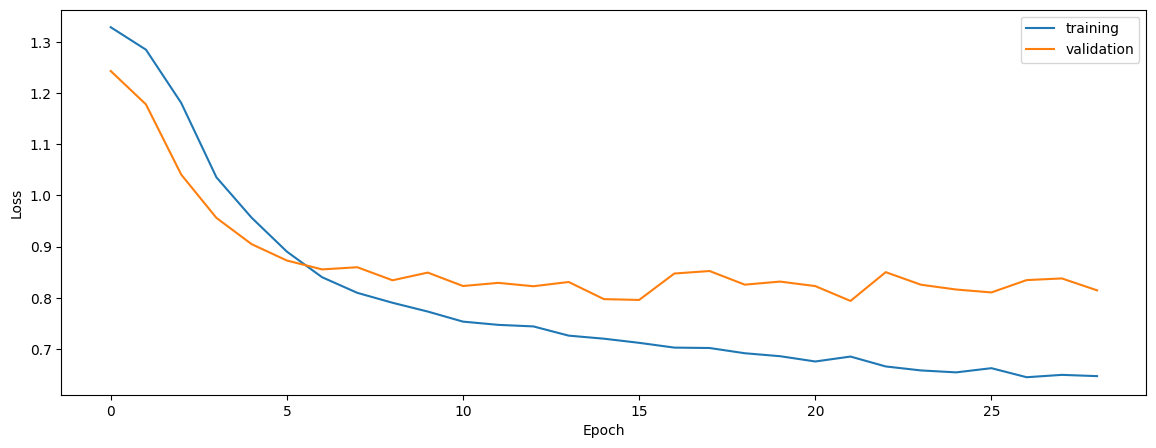

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7263198722336299
0.7007852839931153
0.671992932245539


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.7263198722336299
0.7007852839931153
0.671992932245539


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7212087542957546
0.6908350753658268
0.6750047375402691


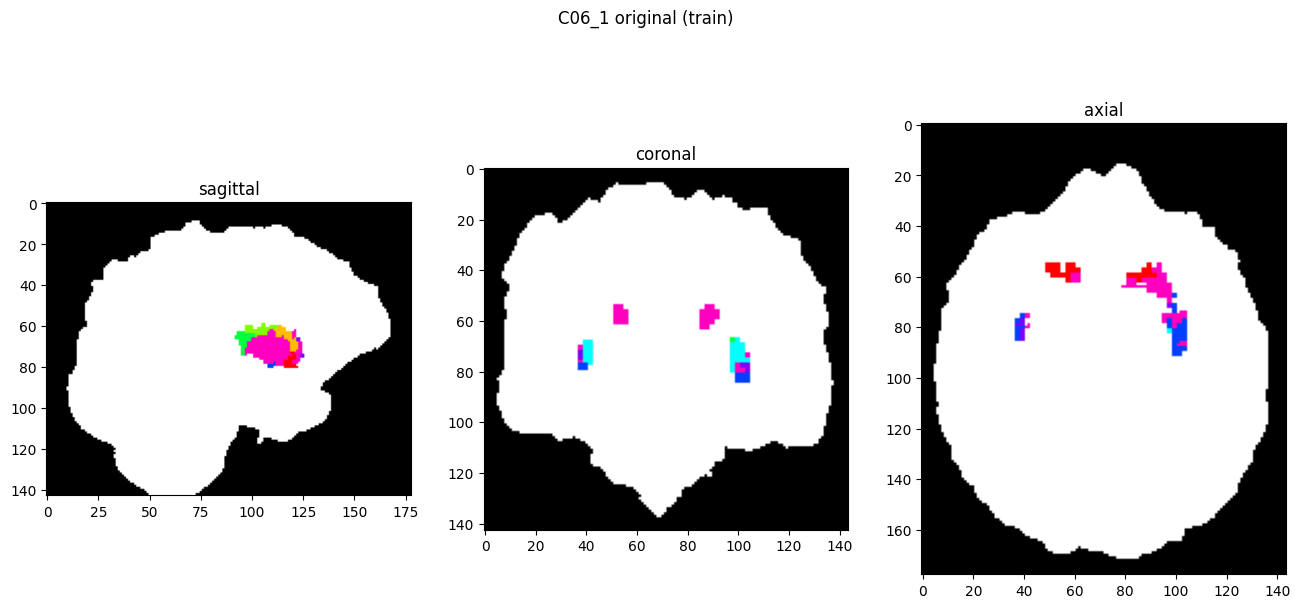

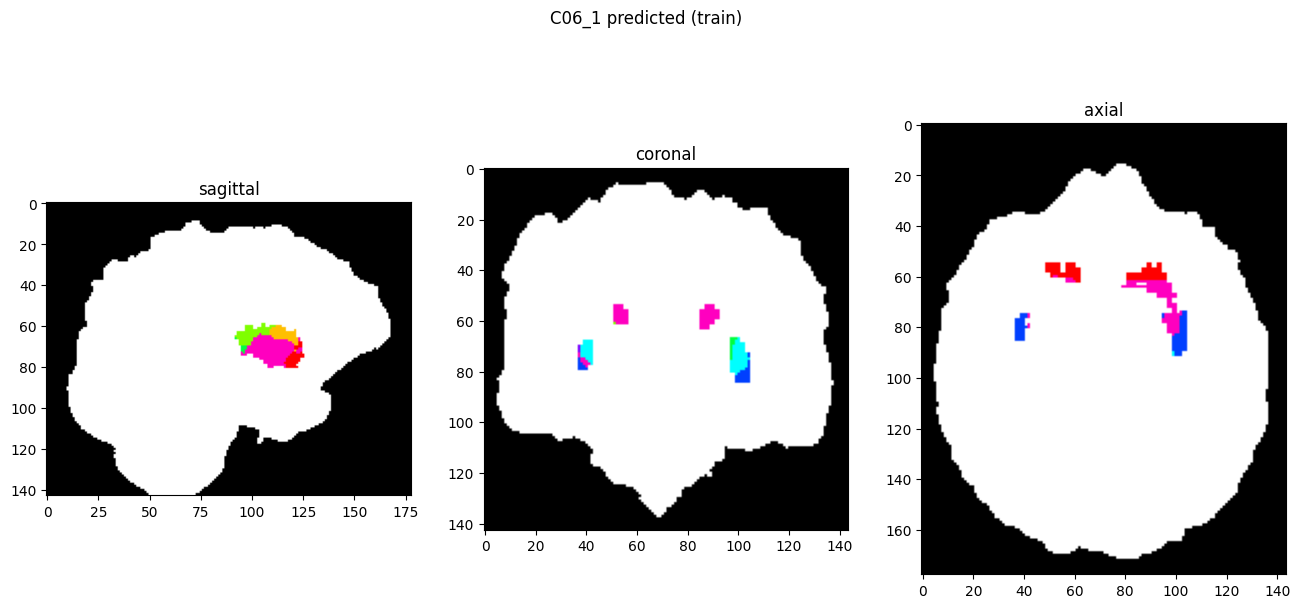

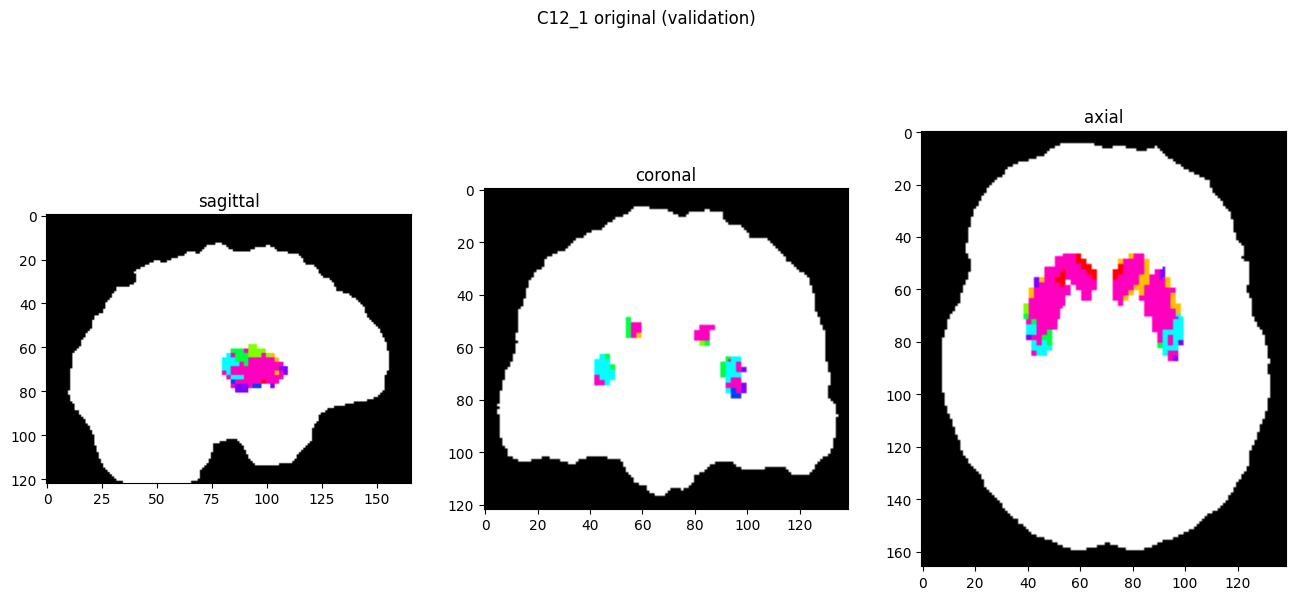

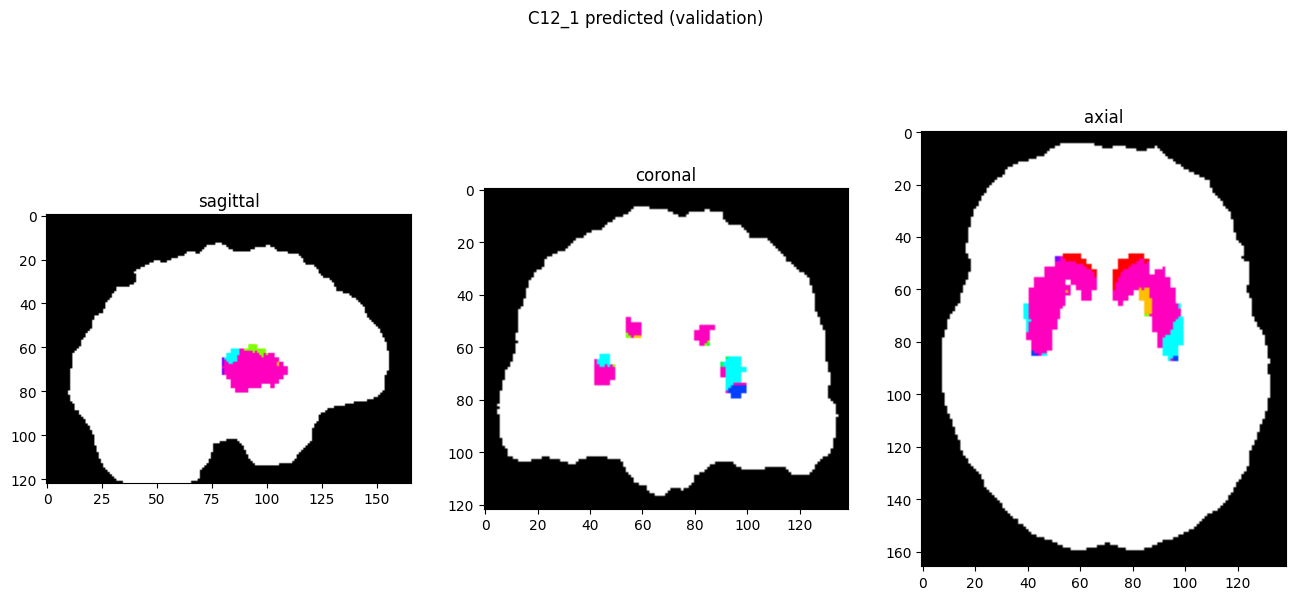

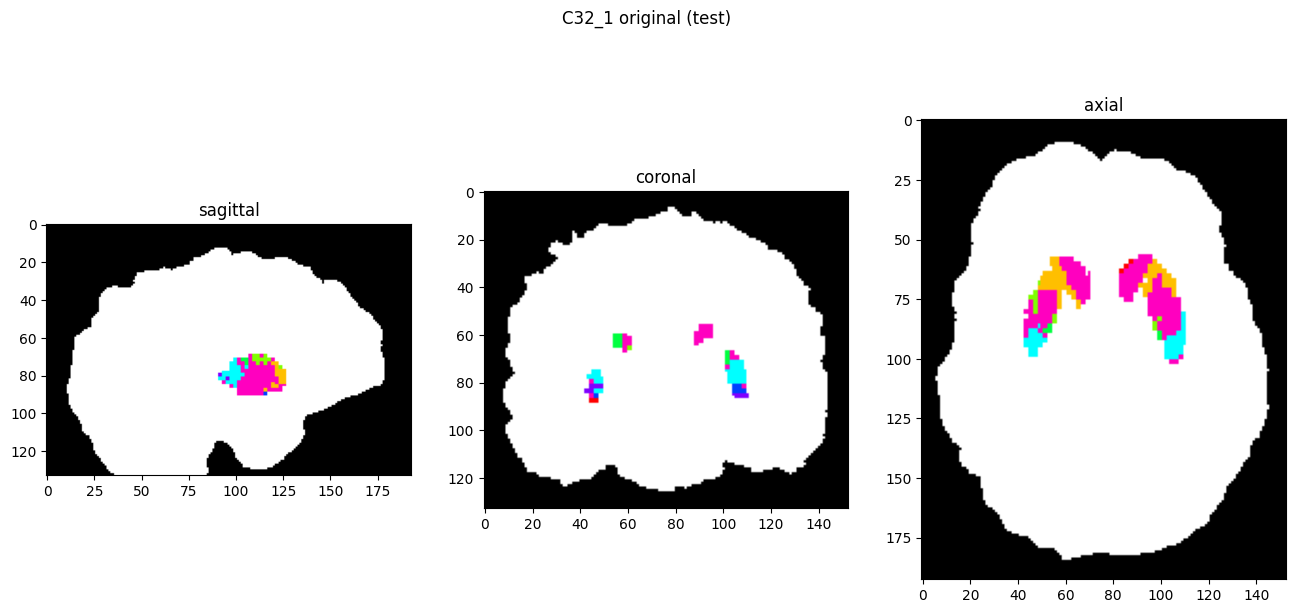

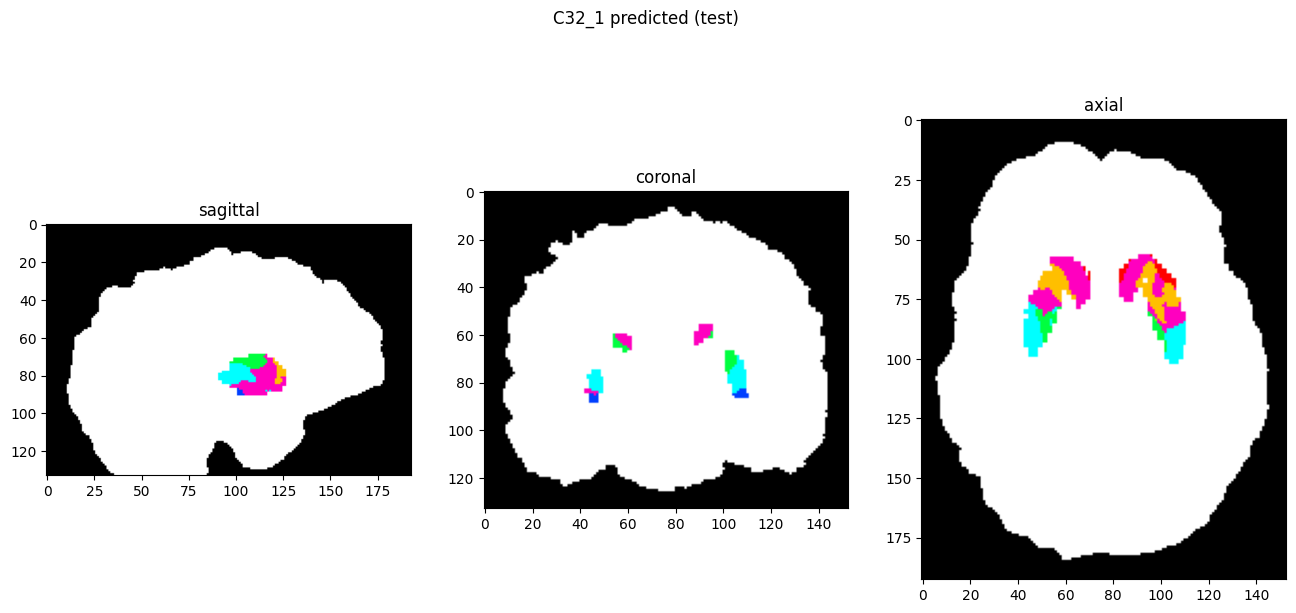

In [10]:
showResults(model, gen, threshold=0)